In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

Setting environment for Gordon


No vtk


In [3]:
stack_fixed = 'MD642'
stack_moving = 'atlasV2'

In [120]:
classifier_setting = 2
warp_setting = 10

In [121]:
if warp_setting == 1:
    upstream_warp_setting = None
    transform_type = 'affine'
    
    terminate_thresh = 1e-6
    grad_computation_sample_number = 1e5
    grid_search_sample_number = 1000
    grid_search_iteration_number = 30
    std_tx = 50
    std_ty = 50
    std_tz = 50
    std_theta_xy = np.deg2rad(10)

elif warp_setting == 7:
    upstream_warp_setting = None
    transform_type = 'rigid'
    
    terminate_thresh = 1e-6
    grad_computation_sample_number = 1e5
    grid_search_sample_number = 1000
    grid_search_iteration_number = 30
    std_tx = 50
    std_ty = 50
    std_tz = 50
    std_theta_xy = np.deg2rad(10)
    
elif warp_setting == 10:
    upstream_warp_setting = None
    transform_type = 'rigid'
    
    terminate_thresh = 1e-6
    grad_computation_sample_number = 1e5
    grid_search_sample_number = 10000
    grid_search_iteration_number = 30
    std_tx = 300
    std_ty = 300
    std_tz = 300
    std_theta_xy = np.deg2rad(10)

elif warp_setting == 11:
    upstream_warp_setting = None
    transform_type = 'affine'
    
    terminate_thresh = 1e-6
    grad_computation_sample_number = 1e5
    grid_search_sample_number = 10000
    grid_search_iteration_number = 30
    std_tx = 300
    std_ty = 300
    std_tz = 300
    std_theta_xy = np.deg2rad(10)

else:
    raise Exception('Warp setting not recognized.')

In [7]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_score_volume_all_known_structures(stack=stack_moving, sided=True)

print volume_moving[1].shape

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_annotationVolume/atlasV2_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


(344, 418, 373)


File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_scoreVolume/score_volumes/atlasV2_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/atlasV2_down32_scoreVolume/score_volumes/atlasV2_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (344, 418, 373)


In [8]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)

print volume_fixed[1].shape

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


(487, 897, 387)


File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_2/score_volumes/MD642_down32_scoreVolume_clf_2_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_2/score_volumes/MD642_down32_scoreVolume_clf_2_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (487, 897, 387)


In [9]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in ['7N_L', '7N_R', '12N', '5N_L', '5N_R', 'Pn_L', 'Pn_R', 'SNR_L', 'SNR_R',
                                  'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCP_L',
                                  'VCA_R', 'VCP_R']}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [9]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [10]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [10]:
label_weights_m = {}
for label_m, name_m in label_to_structure_moving.iteritems():
    if 'surround' in name_m:
        label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1
#         label_weights_m[label_m] = np.minimum(1e5 / volume_moving_structure_sizes[label_m], 1.)

# Compute Registration

In [11]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [12]:
aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

In [13]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
                                                          classifier_setting=classifier_setting)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [14]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins

set([2, 5, 7, 8, 16, 21, 25, 26, 27, 28])


load gradient 2: 12.181878 seconds
load gradient 5: 9.264624 seconds
load gradient 7: 9.553990 seconds
load gradient 8: 14.176127 seconds
load gradient 16: 20.346516 seconds
load gradient 21: 17.460957 seconds
load gradient 25: 13.514834 seconds
load gradient 26: 9.995059 seconds
load gradient 27: 10.800050 seconds
load gradient 28: 10.136722 seconds
overall: 127.432222 seconds


In [15]:
aligner.set_label_weights(label_weights=label_weights_m)

In [ ]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

# while True:
for _ in range(1):

    try:
        T, scores = aligner.optimize(type=transform_type, max_iter_num=1000, history_len=10, 
                                     terminate_thresh=terminate_thresh,
                                     grid_search_iteration_number=grid_search_iteration_number,
                                     grid_search_sample_number=grid_search_sample_number,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=10, lr2=0.1,
                                     std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)
        
        break
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


grid search: 75.988504 seconds
-inf 0.432041
grid search: 62.065928 seconds
0.432041 0.443488
grid search: 53.797972 seconds
0.443488 0.456593
grid search: 38.106803 seconds
0.456593 0.458490
grid search: 27.751376 seconds
0.458490 0.477146
grid search: 20.874271 seconds
0.477146 0.481199
grid search: 16.627470 seconds
0.481199 0.482955
grid search: 12.019405 seconds
grid search: 8.793666 seconds
grid search: 6.567710 seconds
0.482955 0.484486
grid search: 4.964917 seconds
0.484486 0.484605
grid search: 3.801142 seconds
0.484605 0.484709
grid search: 3.309364 seconds
grid search: 2.906508 seconds
0.484709 0.485079
grid search: 3.068704 seconds
0.485079 0.485086
grid search: 2.365708 seconds
0.485086 0.485247
grid search: 2.498303 seconds
0.485247 0.485259
grid search: 1.791366 seconds
grid search: 2.423015 seconds
0.485259 0.485345
grid search: 1.916658 seconds
grid search: 1.401652 seconds
grid search: 1.250735 seconds
grid search: 1.010588 seconds
0.485345 0.485351
grid search: 0.853

params_best_upToNow [ 57.77641547  21.68492569   3.1024182    0.08930978]
6.59035543799e-05 0.0
8.70609379411e-05 0.0
5.13983361721e-05 0.0
-0.000111537389994 0.0
6.38893495798e-05 0.0
9.91602634192e-05 0.0
-5.92631936073e-07 0.0
4.83826977015e-06 0.0
-7.35682600737e-06 0.0
9.22284317017e-05 0.0
-1.55133305788e-05 0.0
-5.99945181608e-06 0.0
2.16616225839e-05 0.0
-0.000182144010067 0.0
-0.000264842075586 0.0
2.15558928251e-05 0.0
1.02685759664e-05 0.0
-3.65183107853e-05 0.0
-1.26042814255e-05 0.0
5.37259377837e-05 0.0


step: 0.61 seconds
score: 0.485359
iteration 1


-7.94221202731e-05 0.0
-1.89387534857e-05 0.0
6.38094921708e-05 0.0
-2.52684162259e-05 0.0
0.000152887298584 0.0
-2.09877687693e-06 0.0
-2.20023705363e-05 0.0
-2.4024451375e-06 0.0
6.03653118014e-05 0.0
1.0174587369e-06 0.0
3.65804465413e-05 0.0
-4.36293184757e-06 0.0
-5.06048443913e-05 0.0
9.68251621723e-06 0.0
2.78393450379e-05 0.0
-4.42382800579e-06 0.0
-7.02964778543e-05 0.0
-4.43271043301e-05 0.0
-1.28218485117e-05 0.0
-0.000122797665358 0.0


step: 0.58 seconds
score: 0.374483
iteration 2


-5.59440950155e-05 0.0
-2.22481749654e-05 0.0
-3.93107885122e-06 0.0
-4.16577986479e-05 0.0
-3.64320995212e-05 0.0
3.11233615875e-06 0.0
2.99621635675e-06 0.0
-2.80765216351e-05 0.0
-2.27478182316e-05 0.0
-1.96854841709e-05 0.0
8.405557096e-06 0.0
1.60965355039e-05 0.0
-6.83631994724e-05 0.0
1.70435153246e-05 0.0
3.57065891027e-05 0.0
-4.17527671456e-05 0.0
6.48234059215e-05 0.0


step: 0.59 seconds
score: 0.344658
iteration 3


-4.88926312923e-05 0.0
-0.000120876632035 0.0
0.00011680816555 0.0
2.76641340852e-05 0.0
1.25782669187e-05 0.0
7.45684902668e-05 0.0
1.99675676823e-05 0.0
1.81907063723e-06 0.0
1.35548627377e-06 0.0
0.000174398246884 0.0
-6.80140113831e-06 0.0
-3.4971714139e-05 0.0
-7.93912827969e-07 0.0
-0.000105151126742 0.0
2.05141741037e-06 0.0
1.82591655254e-05 0.0
-2.97711408138e-06 0.0
6.8100966692e-05 0.0
-9.60916787386e-05 0.0
3.58355041146e-05 0.0


step: 0.56 seconds
score: 0.377347
iteration 4


-6.56519752741e-06 0.0
-0.000107724586248 0.0
0.000119007484317 0.0
6.57782295346e-05 0.0
8.67743593454e-06 0.0
2.7818053782e-05 0.0
-6.58142858744e-06 0.0
-1.46128708124e-06 0.0
0.000106171459854 0.0
3.9440159142e-05 0.0
-1.85692864656e-06 0.0
4.38161349297e-06 0.0
-8.53846679926e-05 0.0
-6.95276549459e-05 0.0
-1.32813900113e-05 0.0
1.30568808913e-05 0.0
0.000127050859749 0.0
9.50797099471e-05 0.0
1.71271398067e-05 0.0


step: 0.62 seconds
score: 0.402557
iteration 5


-5.61407986879e-05 0.0
-0.000144611900806 0.0
-0.000248298547089 0.0
5.59874796867e-06 0.0
-2.69649470448e-05 0.0
-4.07577140927e-05 0.0
-2.12488645315e-06 0.0
6.17513537407e-07 0.0
0.000156818941414 0.0
-3.27212263346e-05 0.0
5.26494204998e-07 0.0
1.5234380722e-05 0.0
-9.96088010073e-05 0.0
-0.000180969587982 0.0
-2.67735583782e-05 0.0
5.54617065191e-06 0.0
-0.000281224650264 0.0
1.55847024918e-06 0.0
-2.20421501994e-05 0.0


step: 0.63 seconds
score: 0.344737
iteration 6


2.79403431416e-05 0.0
-7.96779594421e-05 0.0
6.56029927731e-06 0.0
6.41842685938e-05 0.0
3.46637539864e-05 0.0
5.67727664709e-05 0.0
-1.16691507101e-05 0.0
-1.27217073441e-05 0.0
7.9016059041e-05 0.0
2.96496984959e-05 0.0
-7.37931597233e-06 0.0
-2.71743088961e-06 0.0
-1.03977389932e-05 0.0
-0.000142051270425 0.0
5.59898644686e-06 0.0
7.65657031536e-06 0.0
6.8288564086e-06 0.0
3.37599130273e-05 0.0
-4.69111084938e-06 0.0
4.22453576326e-05 0.0


step: 0.61 seconds
score: 0.403252
iteration 7


-6.9460229218e-05 0.0
1.1203352809e-06 0.0
6.26019137502e-05 0.0
4.30869819522e-05 0.0
4.07322302461e-05 0.0
-7.80692178011e-06 0.0
-2.64569932222e-06 0.0
6.95532557368e-05 0.0
5.13992751241e-05 0.0
-2.09924191236e-06 0.0
-1.55304395556e-05 0.0
-4.40071018934e-05 0.0
-8.25715446472e-05 0.0
-2.44220000505e-06 0.0
3.86741816998e-07 0.0
2.76145914197e-05 0.0
1.03825942874e-05 0.0
2.71587382555e-05 0.0
0.000117570313394 0.0
-0.000101347281694 0.0


step: 0.61 seconds
score: 0.403072
iteration 8


-5.18750053048e-05 0.0
5.91685999036e-05 0.0
2.63118841648e-05 0.0
4.94405363202e-05 0.0
-7.03564363718e-06 0.0
-1.48447871208e-07 0.0
7.55484047532e-05 0.0
3.89240757227e-05 0.0
-5.04219990969e-06 0.0
-5.61032289267e-06 0.0
-0.000113383312523 0.0
-6.15542768836e-05 0.0
5.71065992117e-05 0.0
2.38586008549e-06 0.0
-1.67602263093e-05 0.0
0.000123467451394 0.0
3.26275679469e-05 0.0


step: 0.61 seconds
score: 0.411606
iteration 9


5.91152959466e-05 0.0
-0.000104346950412 0.0
-4.92181500196e-05 0.0
1.47031689286e-05 0.0
5.40503601432e-05 0.0
2.24636064768e-05 0.0
-1.30465459824e-06 0.0
-2.79878055453e-05 0.0
8.9844784081e-05 0.0
1.17205745578e-05 0.0
8.65038478374e-06 0.0
6.81655806303e-06 0.0
-0.000218274250627 0.0
-4.46749444604e-05 0.0
6.14528762698e-05 0.0
3.56688797474e-06 0.0
-1.92082497478e-05 0.0
0.000184698097169 0.0
1.95489528179e-05 0.0
4.1966076076e-05 0.0


step: 0.61 seconds
score: 0.416199
iteration 10


-8.94036507607e-05 0.0
-5.17016665339e-05 0.0
8.16511934996e-06 0.0
3.78140190244e-05 0.0
-3.30722254515e-06 0.0
-3.49548393488e-06 0.0
-3.53853496313e-05 0.0
0.000114371104717 0.0
2.11351197958e-06 0.0
1.63073903918e-05 0.0
1.76198055744e-05 0.0
-0.000241430309772 0.0
-7.52042389512e-05 0.0
4.47134599686e-05 0.0
1.5634304285e-07 0.0
-4.39715572e-05 0.0
0.000163595080972 0.0
4.41523256302e-05 0.0
2.96932422519e-05 0.0
-5.24712105989e-05 0.0


step: 0.62 seconds
score: 0.419672
iteration 11


-0.00011713136363 0.0
-8.15059961677e-05 0.0
3.24257190228e-05 0.0
1.41581264138e-05 0.0
-7.34882283211e-06 0.0
-1.79827122688e-05 0.0
7.9373837769e-05 0.0
8.32487994432e-06 0.0
6.17128509283e-06 0.0
5.50749511719e-05 0.0
-0.000250972617745 0.0
-3.12019810081e-05 0.0
5.46889544129e-05 0.0
4.04474502802e-06 0.0
-4.12746346593e-05 0.0
0.000171901894093 0.0
4.3263071239e-05 0.0


step: 0.60 seconds
score: 0.424498
iteration 12


5.45612897277e-05 0.0
8.29942142963e-05 0.0
-5.52611506581e-05 0.0
5.64114183187e-05 0.0
0.000125735268772 0.0
4.85916376114e-06 0.0
-1.42784608603e-05 0.0
-1.65018791556e-05 0.0
8.92154209018e-05 0.0
9.00866276026e-06 0.0
2.75150209665e-06 0.0
1.72087596059e-05 0.0
-0.000269790170372 0.0
-7.74710868597e-05 0.0
5.76915246844e-05 0.0
2.77530055046e-05 0.0
-7.98591901064e-05 0.0
6.68541802764e-05 0.0
3.61622399092e-05 0.0
5.42090111971e-06 0.0


step: 0.61 seconds
score: 0.447384
iteration 13


0.000102517078638 0.0
-0.000121898909867 0.0
-3.24104933143e-05 0.0
0.000114577037096 0.0
-1.68302522898e-05 0.0
-2.03385907412e-06 0.0
1.5986148715e-06 0.0
4.96110233068e-05 0.0
1.07453401089e-05 0.0
2.91195440292e-06 0.0
6.10913200974e-05 0.0
-0.000201867328048 0.0
-5.3309284091e-05 0.0
6.33971390128e-05 0.0
-1.51102605462e-05 0.0
-1.75286332369e-05 0.0
-1.19064299464e-05 0.0
1.2207369566e-05 0.0
7.56424921155e-05 0.0
0.000150479656041 0.0


step: 0.61 seconds
score: 0.449981
iteration 14


-8.84595574737e-05 0.0
9.99206775427e-05 0.0
0.000141446471572 0.0
4.56598079205e-06 0.0
-1.01837515831e-06 0.0
-6.11233371496e-06 0.0
7.06331391335e-05 0.0
9.13884791732e-05 0.0
4.08739609718e-05 0.0
-4.68868076801e-06 0.0
8.18870170116e-05 0.0
0.000101760268569 0.0
3.93374234438e-06 0.0
5.21179077625e-05 0.0
-8.20313938856e-05 0.0
9.64368724823e-06 0.0
7.17635353208e-05 0.0


step: 0.61 seconds
score: 0.417553
iteration 15


-9.0537560761e-05 0.0
-0.000201315833509 0.0
-6.42316426635e-05 0.0
-0.00014551292181 0.0
-1.23148460388e-05 0.0
-2.63896313906e-05 0.0
-1.19365828633e-05 0.0
-1.24683422446e-05 0.0
5.87387071252e-05 0.0
2.36021943688e-05 0.0
3.97939801216e-06 0.0
4.55186583996e-05 0.0
-8.49077093005e-05 0.0
-0.000207422381341 0.0
-1.32830060124e-05 0.0
-2.85502013564e-05 0.0
-9.99048378468e-05 0.0
4.92894803286e-05 0.0
5.66137769818e-05 0.0
8.31038806438e-05 0.0


step: 0.61 seconds
score: 0.414420
iteration 16


0.00020930195713 0.0
-6.10840151906e-05 0.0
0.000125926245511 0.0
0.000104311778426 0.0
4.39555907249e-06 0.0
1.31380191445e-05 0.0
-1.14414557815e-05 0.0
3.03974639773e-05 0.0
5.43183454275e-05 0.0
1.17072383165e-05 0.0
-2.26209033132e-05 0.0
3.09046202302e-05 0.0
-5.39056885242e-05 0.0
2.23527077436e-05 0.0
6.49365109801e-05 0.0
-7.84880657792e-05 0.0
4.3413813889e-05 0.0
8.07378866076e-05 0.0
-3.93708245158e-05 0.0
-0.000124334114671 0.0


step: 0.61 seconds
score: 0.455692
iteration 17


-4.83707600832e-05 0.0
-3.06653671861e-05 0.0
-2.69418168664e-05 0.0
-3.45058829188e-05 0.0
-1.4696590066e-05 0.0
-3.48760867119e-06 0.0
5.01474680305e-05 0.0
1.19097828865e-06 0.0
1.20014233589e-05 0.0
3.86125812531e-05 0.0
-0.000151414132178 0.0
-0.000223825319171 0.0
1.4737942934e-05 0.0
-1.85659857988e-05 0.0
-8.91126251817e-05 0.0
4.96980387568e-05 0.0
9.50973516703e-06 0.0


step: 0.61 seconds
score: 0.440300
iteration 18


6.70076721311e-05 0.0
0.000148307112396 0.0
-8.51831629872e-05 0.0
9.20347875953e-05 0.0
9.09734252095e-05 0.0
-1.13623297215e-06 0.0
-8.84844064713e-07 0.0
-1.77045358419e-05 0.0
6.10511091948e-05 0.0
4.52774916291e-05 0.0
1.29312492609e-05 0.0
-7.69457006454e-06 0.0
-0.000105178049505 0.0
-0.000160869470716 0.0
1.95561925769e-05 0.0
7.06737955809e-05 0.0
-0.00011975108397 0.0
5.18179916739e-05 0.0
1.76281257868e-05 0.0
5.13830851912e-05 0.0


step: 0.61 seconds
score: 0.465723
iteration 19


8.83791678548e-05 0.0
-0.00012277083987 0.0
8.78406509757e-05 0.0
0.000126086484253 0.0
-3.07577571273e-05 0.0
3.02457785606e-06 0.0
4.44108194113e-06 0.0
8.54905317426e-05 0.0
3.3068087101e-06 0.0
-2.93079018593e-06 0.0
1.15129422545e-05 0.0
-0.000254489516854 0.0
-0.00027233644259 0.0
2.32442518473e-05 0.0
4.05834859014e-05 0.0
-5.30835245252e-05 0.0
1.25727413893e-05 0.0
5.8685171783e-05 0.0
0.000103233701289 0.0
0.000147705777287 0.0


step: 0.61 seconds
score: 0.485646
iteration 20


-8.97141559124e-05 0.0
0.000105492964208 0.0
0.000110849405706 0.0
-6.02661818266e-06 0.0
2.63805663586e-06 0.0
1.10893477201e-05 0.0
7.3067255199e-05 0.0
-2.4007871151e-06 0.0
-8.7628620863e-07 0.0
-1.03505062461e-05 0.0
-0.000188700351715 0.0
-0.000235010976732 0.0
2.51188779473e-05 0.0
5.93993014097e-05 0.0
-4.92850904465e-05 0.0
2.66836997867e-05 0.0
3.91366705894e-05 0.0


step: 0.61 seconds
score: 0.485803
iteration 21


7.69664080143e-05 0.0
5.79390451312e-05 0.0
-6.32793335915e-05 0.0
0.000106045277178 0.0
9.18319963813e-05 0.0
-3.31417602897e-05 0.0
3.57072085142e-06 0.0
1.14253511429e-05 0.0
5.32233259678e-05 0.0
-9.88651353121e-06 0.0
-1.17702543736e-07 0.0
1.05167188048e-05 0.0
-0.000235274798155 0.0
-0.00027467816174 0.0
1.12373132706e-05 0.0
3.35797405839e-05 0.0
-6.76519014239e-05 0.0
5.25818615556e-05 0.0
5.15988463759e-05 0.0
8.15422103405e-05 0.0


step: 0.61 seconds
score: 0.488590
iteration 22


6.70101168156e-05 0.0
-0.000111050795436 0.0
9.93045071959e-05 0.0
0.000120703305006 0.0
-2.51640667319e-05 0.0
2.40555495024e-06 0.0
1.02395614982e-05 0.0
8.34324157238e-05 0.0
1.97791004181e-06 0.0
-3.04284328222e-06 0.0
8.44735479355e-06 0.0
-0.00024888299942 0.0
-0.0002633248505 0.0
1.74693565369e-05 0.0
4.09001891613e-05 0.0
-5.8545322597e-05 0.0
4.1869143188e-05 0.0
4.33389442563e-05 0.0
8.37309111357e-05 0.0
9.39114942551e-05 0.0


step: 0.61 seconds
score: 0.488771
iteration 23


-9.66079489589e-05 0.0
9.87271096706e-05 0.0
0.000116763299108 0.0
-2.26004160643e-05 0.0
8.16860002279e-06 0.0
1.11478618383e-05 0.0
6.82976647615e-05 0.0
-2.16370379925e-06 0.0
-2.13115257025e-06 0.0
4.89084464312e-06 0.0
-0.000227168485045 0.0
-0.000259874143839 0.0
2.05309870243e-05 0.0
5.08604252338e-05 0.0
-5.47786548138e-05 0.0
3.17396147847e-05 0.0
4.13928339481e-05 0.0


step: 0.61 seconds
score: 0.488531
iteration 24


9.68488503695e-05 0.0
9.63791100979e-05 0.0
-0.000136396899581 0.0
9.69265918732e-05 0.0
0.000132790231824 0.0
-1.93445577621e-05 0.0
1.33895653486e-06 0.0
9.17341542244e-06 0.0
9.09890165925e-05 0.0
2.83008950949e-06 0.0
-3.19564396143e-06 0.0
8.82266825438e-06 0.0
-0.000235566986561 0.0
-0.000251649656892 0.0
2.05458266735e-05 0.0
4.91355372071e-05 0.0
-3.47498816252e-05 0.0
3.84226145744e-05 0.0
2.72368117571e-05 0.0
7.26604731679e-05 0.0


step: 0.61 seconds
score: 0.488526
iteration 25


7.00043557286e-05 0.0
-8.04245887399e-05 0.0
9.97981786132e-05 0.0
0.000108305505514 0.0
-2.9347428441e-05 0.0
3.6465061307e-06 0.0
8.54409897327e-06 0.0
6.13694409728e-05 0.0
-4.35504430532e-06 0.0
-2.74295097589e-06 0.0
8.40745067596e-06 0.0
-0.000237740618765 0.0
-0.000253914008796 0.0
1.59611616135e-05 0.0
3.30482522249e-05 0.0
-5.39334514141e-05 0.0
3.75613994002e-05 0.0
5.03824428916e-05 0.0
8.98768673539e-05 0.0
9.99842742085e-05 0.0


step: 0.61 seconds
score: 0.489180
iteration 26


-0.000107741792083 0.0
7.76096923351e-05 0.0
0.000140119088888 0.0
-1.80288223028e-05 0.0
2.84276902676e-06 0.0
9.09646034241e-07 0.0
9.77800481915e-05 0.0
1.34019591212e-05 0.0
-4.65702188015e-06 0.0
1.14025466442e-05 0.0
-0.000243146100104 0.0
-0.00023883845067 0.0
1.88488331437e-05 0.0
5.26145444512e-05 0.0
-5.18438869715e-05 0.0
2.48673129082e-05 0.0
2.69292250276e-05 0.0


step: 0.61 seconds
score: 0.487025
iteration 27


8.56774267554e-05 0.0
0.000119735689044 0.0
-8.06279275417e-05 0.0
0.000106673228145 0.0
9.72677201033e-05 0.0
-1.78704503775e-05 0.0
8.69207280874e-06 0.0
9.19760298729e-06 0.0
4.71268826723e-05 0.0
-1.96491765976e-06 0.0
6.9611620903e-07 0.0
7.04675912857e-09 0.0
-0.000193488249004 0.0
-0.000262266340017 0.0
1.84798170328e-05 0.0
3.75284898877e-05 0.0
-6.24721919298e-05 0.0
3.46809147e-05 0.0
6.73876911402e-06 0.0
0.000108743221998 0.0


step: 0.61 seconds
score: 0.486597
iteration 28


9.44061996937e-05 0.0
-6.46069799066e-05 0.0
8.458021456e-05 0.0
0.000143689362049 0.0
-1.91330494285e-05 0.0
3.89318686724e-06 0.0
-2.90094226599e-06 0.0
0.00010164488554 0.0
3.1312609911e-06 0.0
-3.43207901716e-06 0.0
7.4189953804e-06 0.0
-0.000237162315011 0.0
-0.000253044424295 0.0
2.46863672733e-05 0.0
6.204278332e-05 0.0
-5.44026582241e-05 0.0
1.09189347029e-05 0.0
5.13390998244e-05 0.0
0.000110813831508 0.0
9.17239211798e-05 0.0


step: 0.61 seconds
score: 0.486958
iteration 29


-0.000109309088767 0.0
9.51424473524e-05 0.0
0.000115718214333 0.0
-1.72861509919e-05 0.0
6.53354054689e-06 0.0
1.2616486907e-05 0.0
7.57714262605e-05 0.0
-2.0799049139e-06 0.0
-2.60569512844e-06 0.0
4.99041825533e-06 0.0
-0.000217215376973 0.0
-0.000266112605631 0.0
2.42826454639e-05 0.0
5.64405841827e-05 0.0
-3.95374599099e-05 0.0
2.66995385885e-05 0.0
2.92023418546e-05 0.0


step: 0.61 seconds
score: 0.488402
iteration 30


9.58593931198e-05 0.0
6.41015409827e-05 0.0
-7.63087014556e-05 0.0
9.94675050378e-05 0.0
0.000109025292993 0.0
-2.40601679087e-05 0.0
3.84576880932e-06 0.0
1.01090747714e-05 0.0
6.77873656154e-05 0.0
-4.31619781256e-06 0.0
-2.67871928215e-06 0.0
8.64026671648e-06 0.0
-0.000234738650858 0.0
-0.000263174655497 0.0
1.39177859426e-05 0.0
3.06689055562e-05 0.0
-6.05554382205e-05 0.0
3.8390278995e-05 0.0
5.71592541933e-05 0.0
9.91573089361e-05 0.0


step: 0.61 seconds
score: 0.489371
iteration 31


7.64550273418e-05 0.0
-0.000115015466988 0.0
8.95049124956e-05 0.0
0.000140706638157 0.0
-1.41061908603e-05 0.0
2.52542895079e-06 0.0
5.3208964467e-06 0.0
8.68866530061e-05 0.0
7.81667011976e-06 0.0
-4.48538666964e-06 0.0
1.04343879223e-05 0.0
-0.000237663787425 0.0
-0.000253318133533 0.0
2.18313483596e-05 0.0
4.65249004364e-05 0.0
-4.95664407611e-05 0.0
3.33901953101e-05 0.0
1.7370846808e-05 0.0
9.4599136591e-05 0.0
8.81496725082e-05 0.0


step: 0.61 seconds
score: 0.488348
iteration 32


-9.60113500357e-05 0.0
0.000100324042976 0.0
0.000109422743618 0.0
-1.70075832009e-05 0.0
8.68475055695e-06 0.0
1.39431967139e-05 0.0
5.94192267656e-05 0.0
1.20085865259e-06 0.0
-8.13210904598e-07 0.0
2.62455713749e-06 0.0
-0.000204564730227 0.0
-0.000267600191653 0.0
1.94827337265e-05 0.0
4.5621455729e-05 0.0
-5.20106095672e-05 0.0
3.33225609064e-05 0.0
4.10009381175e-05 0.0


step: 0.61 seconds
score: 0.488066
iteration 33


8.696425879e-05 0.0
8.60559988022e-05 0.0
-0.000116177054644 0.0
9.08056102991e-05 0.0
0.000137890015244 0.0
-1.35873470902e-05 0.0
2.8229290247e-06 0.0
1.79527723789e-06 0.0
9.65863139033e-05 0.0
4.15150874853e-06 0.0
-3.84178543091e-06 0.0
7.23267298937e-06 0.0
-0.00023429401356 0.0
-0.000254773991525 0.0
1.78587347269e-05 0.0
5.91642660499e-05 0.0
-5.75938203931e-05 0.0
1.05474443436e-05 0.0
4.86522781849e-05 0.0
0.000119038043499 0.0


step: 0.61 seconds
score: 0.487901
iteration 34


9.34341265559e-05 0.0
-0.000106917182982 0.0
8.99923595786e-05 0.0
0.000122716170549 0.0
-1.36842701435e-05 0.0
5.97723048925e-06 0.0
1.27378605604e-05 0.0
7.83639751077e-05 0.0
-2.73963081837e-06 0.0
-3.02559834719e-06 0.0
3.90437620878e-06 0.0
-0.000224380224943 0.0
-0.000251501369238 0.0
1.77619418502e-05 0.0
5.67289530039e-05 0.0
-4.53656452298e-05 0.0
2.78570623994e-05 0.0
4.4194237411e-05 0.0
8.20352762341e-05 0.0
5.99630547762e-05 0.0


step: 0.61 seconds
score: 0.488285
iteration 35


-8.15736092329e-05 0.0
9.67383900881e-05 0.0
0.000125493303835 0.0
-1.99836088419e-05 0.0
1.43092733622e-06 0.0
9.22873079777e-06 0.0
7.78024750352e-05 0.0
-1.08099812269e-06 0.0
-4.61890631914e-06 0.0
9.70106625557e-06 0.0
-0.000238036203146 0.0
-0.000261798338234 0.0
1.84039069414e-05 0.0
3.09200726748e-05 0.0
-5.23679248691e-05 0.0
4.03070135117e-05 0.0
2.07121388912e-05 0.0


step: 0.61 seconds
score: 0.489326
iteration 36


0.000111745933712 0.0
8.89876698852e-05 0.0
-0.000105861173451 0.0
8.74801434278e-05 0.0
0.000113351662517 0.0
-1.43618141413e-05 0.0
8.21041458845e-06 0.0
1.11941190958e-05 0.0
6.52445921898e-05 0.0
-6.92530590296e-06 0.0
-1.89661484957e-06 0.0
3.7892781496e-06 0.0
-0.000212793553233 0.0
-0.000268239627898 0.0
2.00941819549e-05 0.0
4.72779920697e-05 0.0
-5.40257588029e-05 0.0
3.47172980905e-05 0.0
4.29923291206e-05 0.0
0.000116622919679 0.0


step: 0.61 seconds
score: 0.488267
iteration 37


0.000105192873955 0.0
-0.000101673594475 0.0
8.18636259437e-05 0.0
0.000141932474673 0.0
-9.28144216537e-06 0.0
4.40074855089e-06 0.0
-5.29500246048e-08 0.0
9.66146651506e-05 0.0
8.29498779774e-06 0.0
-3.72450518608e-06 0.0
6.3739720583e-06 0.0
-0.000226188931286 0.0
-0.00025144003886 0.0
1.82919437289e-05 0.0
5.99992654324e-05 0.0
-4.83714023829e-05 0.0
9.77665424347e-06 0.0
2.35601783395e-05 0.0
9.16841136217e-05 0.0
8.81409081221e-05 0.0


step: 0.61 seconds
score: 0.487525
iteration 38


-9.36735727191e-05 0.0
9.53015958071e-05 0.0
0.000115373744249 0.0
-1.97330778241e-05 0.0
6.83258217573e-06 0.0
7.4832098484e-06 0.0
6.77641182542e-05 0.0
-5.56145727634e-06 0.0
-3.48485898972e-06 0.0
7.013872087e-06 0.0
-0.000225957124591 0.0
-0.000265939483106 0.0
1.62937072515e-05 0.0
4.02284781933e-05 0.0
-4.71056562662e-05 0.0
3.80884831548e-05 0.0
5.36922059059e-05 0.0


step: 0.61 seconds
score: 0.488907
iteration 39


8.84791644812e-05 0.0
9.15599814653e-05 0.0
-0.000104615074337 0.0
6.7076503396e-05 0.0
0.000135478336096 0.0
-1.88571359515e-05 0.0
4.64708453417e-06 0.0
-1.52763450146e-06 0.0
9.25493590832e-05 0.0
1.64111650586e-05 0.0
-5.81008046865e-06 0.0
1.35268254876e-05 0.0
-0.000238636079431 0.0
-0.000243131106913 0.0
1.8444373548e-05 0.0
3.847523278e-05 0.0
-5.97477117181e-05 0.0
1.61375598907e-05 0.0
3.33326637149e-05 0.0
0.000108151347458 0.0


step: 0.61 seconds
score: 0.486134
iteration 40


0.00012103961724 0.0
-9.70733083487e-05 0.0
9.8546942234e-05 0.0
9.42345250249e-05 0.0
-6.81410014629e-06 0.0
1.23631937504e-05 0.0
9.95039778948e-06 0.0
4.93529816866e-05 0.0
1.58588904142e-06 0.0
-1.2640529871e-07 0.0
-3.8692420125e-06 0.0
-0.000169695161045 0.0
-0.000254993105471 0.0
2.31353113651e-05 0.0
4.35967377424e-05 0.0
-5.36434765458e-05 0.0
2.2446846664e-05 0.0
9.88047432899e-06 0.0
0.000118182046413 0.0
0.000109149755657 0.0


step: 0.61 seconds
score: 0.484807
iteration 41


-5.4968865633e-05 0.0
8.08789044023e-05 0.0
0.00014525014621 0.0
-8.63912558556e-06 0.0
3.52722895145e-06 0.0
-7.63467329741e-06 0.0
0.000100071950197 0.0
-2.20171743631e-06 0.0
-4.71485602856e-06 0.0
7.34551769495e-06 0.0
-0.000232396664381 0.0
-0.000254075985909 0.0
2.18849238753e-05 0.0
6.26422019601e-05 0.0
-4.81716573238e-05 0.0
1.0820181191e-05 0.0
1.84853869081e-05 0.0


step: 0.61 seconds
score: 0.486292
iteration 42


0.000107459186912 0.0
9.31220076084e-05 0.0
-0.000101735548913 0.0
9.33258840442e-05 0.0
0.000108405724823 0.0
-1.66861736178e-05 0.0
8.165574193e-06 0.0
1.25340057015e-05 0.0
6.13815056682e-05 0.0
-1.95930767059e-06 0.0
-1.68643909693e-06 0.0
4.43331050873e-06 0.0
-0.000206245112181 0.0
-0.000280273841321 0.0
1.96074626446e-05 0.0
4.93824510574e-05 0.0
-6.51013330221e-05 0.0
3.75045337081e-05 0.0
5.39623689651e-05 0.0
0.000126868950725 0.0


step: 0.61 seconds
score: 0.488673
iteration 43


7.99545175433e-05 0.0
-0.000126624599934 0.0
9.21851369739e-05 0.0
0.000141034607947 0.0
-1.4378099978e-05 0.0
3.64362001419e-06 0.0
2.22916060686e-06 0.0
9.33812348843e-05 0.0
8.94256901741e-06 0.0
-4.92084771395e-06 0.0
9.59535574913e-06 0.0
-0.000227352355897 0.0
-0.000256467048526 0.0
1.31586869359e-05 0.0
5.67803561687e-05 0.0
-5.16922990084e-05 0.0
2.53378001451e-05 0.0
2.09938025475e-05 0.0
8.96281397939e-05 0.0
7.14076604247e-05 0.0


step: 0.61 seconds
score: 0.488159
iteration 44


-9.7564219296e-05 0.0
9.58596608043e-05 0.0
0.000112647176266 0.0
-1.81099919677e-05 0.0
5.9937710166e-06 0.0
9.35505598783e-06 0.0
6.07917050719e-05 0.0
-3.77466022968e-06 0.0
-3.31733721495e-06 0.0
7.03313940763e-06 0.0
-0.00021324300313 0.0
-0.000270897955477 0.0
1.99251710773e-05 0.0
3.78754732609e-05 0.0
-6.07945480943e-05 0.0
3.61197418571e-05 0.0
4.75280020833e-05 0.0


step: 0.61 seconds
score: 0.489107
iteration 45


0.000101307081461 0.0
0.000113088896811 0.0
-0.000106412006438 0.0
8.21080605984e-05 0.0
0.000145711967766 0.0
-1.29011164308e-05 0.0
3.30456739664e-06 0.0
-3.73763024807e-07 0.0
9.44108818173e-05 0.0
1.27507897019e-05 0.0
-5.26676315069e-06 0.0
8.38340842724e-06 0.0
-0.000225215200603 0.0
-0.000246363919735 0.0
1.81464782953e-05 0.0
5.97428922057e-05 0.0
-4.63831670284e-05 0.0
1.68210107684e-05 0.0
1.4895370245e-05 0.0
9.51219891906e-05 0.0


step: 0.61 seconds
score: 0.487306
iteration 46


8.98644055724e-05 0.0
-8.83786663413e-05 0.0
9.59112048745e-05 0.0
0.000108105295956 0.0
-1.28732171655e-05 0.0
8.86721301079e-06 0.0
1.19625465274e-05 0.0
5.47648052573e-05 0.0
-3.39305436611e-06 0.0
-1.00233060122e-06 0.0
3.36164104939e-06 0.0
-0.00020406855917 0.0
-0.000269242124259 0.0
1.74058049321e-05 0.0
4.49459235668e-05 0.0
-6.19609015584e-05 0.0
3.7600459516e-05 0.0
5.00760892034e-05 0.0
0.000110415507436 0.0
9.45851442814e-05 0.0


step: 0.61 seconds
score: 0.488121
iteration 47


-0.000104791243494 0.0
8.8732888341e-05 0.0
0.000142287476897 0.0
-1.31169131994e-05 0.0
2.97451984882e-06 0.0
1.30655753613e-06 0.0
9.40552998185e-05 0.0
7.1260573864e-06 0.0
-4.80551242828e-06 0.0
8.54704630375e-06 0.0
-0.000223125203371 0.0
-0.000256437262297 0.0
1.24420744181e-05 0.0
5.86275900602e-05 0.0
-4.81565558314e-05 0.0
1.49082188606e-05 0.0
1.76352211237e-05 0.0


step: 0.61 seconds
score: 0.487675
iteration 48


9.65772385597e-05 0.0
7.77620590329e-05 0.0
-9.08292992115e-05 0.0
8.96442735791e-05 0.0
0.000109207858026 0.0
-1.7501119256e-05 0.0
7.17567378283e-06 0.0
1.17645680904e-05 0.0
6.41281929016e-05 0.0
-2.94390887022e-06 0.0
-2.16669625044e-06 0.0
4.57779920101e-06 0.0
-0.000202096158028 0.0
-0.000277630965114 0.0
2.06067854166e-05 0.0
4.64703402519e-05 0.0
-6.25337094665e-05 0.0
3.38984296322e-05 0.0
5.57273007631e-05 0.0
0.000130168076575 0.0


step: 0.61 seconds
score: 0.488564
iteration 49


9.64755490422e-05 0.0
-0.00010009573096 0.0
8.80327638388e-05 0.0
0.000141241702557 0.0
-1.18231129646e-05 0.0
4.59137892723e-06 0.0
6.09644055367e-07 0.0
9.66093069911e-05 0.0
7.67850768566e-06 0.0
-4.8427953124e-06 0.0
8.77344185114e-06 0.0
-0.00022039356941 0.0
-0.000249322658777 0.0
1.63273123503e-05 0.0
5.98834105134e-05 0.0
-6.04737184644e-05 0.0
1.46857913136e-05 0.0
1.69481557608e-05 0.0
9.9886063695e-05 0.0
8.4782453537e-05 0.0


step: 0.61 seconds
score: 0.487440
iteration 50


-9.34400451779e-05 0.0
9.49673835635e-05 0.0
0.000104122134864 0.0
-1.85465189815e-05 0.0
6.69667053223e-06 0.0
9.53703457117e-06 0.0
5.72023677826e-05 0.0
-4.00423693657e-06 0.0
-1.80034637451e-06 0.0
7.38857275248e-06 0.0
-0.000211784842491 0.0
-0.000278028451979 0.0
1.65172826648e-05 0.0
3.70203357935e-05 0.0
-6.86298061013e-05 0.0
3.54820154309e-05 0.0
4.31903101206e-05 0.0


step: 0.61 seconds
score: 0.488790
iteration 51


0.000125470693529 0.0
9.26499061584e-05 0.0
-7.83682459593e-05 0.0
8.15778815746e-05 0.0
0.000144948137164 0.0
-1.24919327497e-05 0.0
4.54860913754e-06 0.0
-4.77812868357e-06 0.0
0.000101764674723 0.0
1.07188677192e-05 0.0
-5.44150477648e-06 0.0
9.40626090765e-06 0.0
-0.000220363271356 0.0
-0.000250161331952 0.0
1.54682033062e-05 0.0
5.80128796697e-05 0.0
-5.0790993154e-05 0.0
1.20100467205e-05 0.0
1.58253840804e-05 0.0
0.000101741584897 0.0


step: 0.61 seconds
score: 0.486949
iteration 52


9.34901503325e-05 0.0
-8.90559719801e-05 0.0
9.58774231672e-05 0.0
0.000101611310542 0.0
-1.76453675032e-05 0.0
7.74731886387e-06 0.0
1.13919504881e-05 0.0
5.58794633746e-05 0.0
-5.15929055214e-06 0.0
-1.2157612443e-06 0.0
4.41501158476e-06 0.0
-0.000196379895091 0.0
-0.000274066479445 0.0
1.51205584407e-05 0.0
4.08074704409e-05 0.0
-6.742150563e-05 0.0
3.27116578221e-05 0.0
5.18248015642e-05 0.0
0.000113223177195 0.0
9.61465815902e-05 0.0


step: 0.61 seconds
score: 0.487981
iteration 53


-0.000115243867815 0.0
9.13081621528e-05 0.0
0.000141090423346 0.0
-1.18421775699e-05 0.0
3.07202959061e-06 0.0
1.78659123182e-06 0.0
9.48013641834e-05 0.0
1.02676237226e-05 0.0
-4.86348831654e-06 0.0
8.79071676731e-06 0.0
-0.000223766952991 0.0
-0.000258289845109 0.0
1.45405007601e-05 0.0
5.37535693645e-05 0.0
-5.8332213819e-05 0.0
2.20390945077e-05 0.0
2.20511689782e-05 0.0


step: 0.61 seconds
score: 0.487990
iteration 54


9.39311816096e-05 0.0
6.55577290058e-05 0.0
-9.53921388984e-05 0.0
8.82524614334e-05 0.0
0.000110955822945 0.0
-1.59960402846e-05 0.0
6.96451187134e-06 0.0
1.18739562035e-05 0.0
6.36979088187e-05 0.0
-7.93902397156e-07 0.0
-2.64290368557e-06 0.0
4.91111296415e-06 0.0
-0.00020733867085 0.0
-0.000278293753862 0.0
1.75866964459e-05 0.0
4.75629939437e-05 0.0
-5.27026010156e-05 0.0
3.543454808e-05 0.0
4.66153835654e-05 0.0
0.000114029147148 0.0


step: 0.61 seconds
score: 0.488214
iteration 55


0.000108235091627 0.0
-9.16709408164e-05 0.0
8.01548799872e-05 0.0
0.000147704351187 0.0
-1.03416288495e-05 0.0
3.12482899427e-06 0.0
-2.83782863617e-06 0.0
9.8422670424e-05 0.0
1.3687618196e-05 0.0
-5.02070742846e-06 0.0
9.11052125692e-06 0.0
-0.000220131244659 0.0
-0.000246209120333 0.0
1.7356505394e-05 0.0
5.87718144655e-05 0.0
-4.30993012786e-05 0.0
1.1816400528e-05 0.0
1.64307596684e-05 0.0
0.000103754085898 0.0
8.43726693392e-05 0.0


step: 0.61 seconds
score: 0.486969
iteration 56


-8.25843897462e-05 0.0
9.80059198141e-05 0.0
9.80087170005e-05 0.0
-1.84466845989e-05 0.0
9.81123334169e-06 0.0
1.22485815883e-05 0.0
5.33344273567e-05 0.0
-5.63652187586e-06 0.0
-7.63945102692e-07 0.0
4.31583368778e-06 0.0
-0.000195540372252 0.0
-0.000273494398773 0.0
1.65221309066e-05 0.0
4.10349546075e-05 0.0
-7.86203981042e-05 0.0
3.18407073021e-05 0.0
4.75066710711e-05 0.0


step: 0.61 seconds
score: 0.487824
iteration 57


0.000109988220274 0.0
0.000112361820281 0.0
-9.39209258556e-05 0.0
8.98340758681e-05 0.0
0.000145576201022 0.0
-1.50026936531e-05 0.0
3.03120112419e-06 0.0
-4.24495995045e-07 0.0
9.64389107227e-05 0.0
8.19282764196e-06 0.0
-4.92545258999e-06 0.0
8.54613679647e-06 0.0
-0.000220431682944 0.0
-0.000259625760913 0.0
1.7140230298e-05 0.0
6.30836277008e-05 0.0
-5.10317864418e-05 0.0
1.19052440524e-05 0.0
1.50111525655e-05 0.0
9.91077519655e-05 0.0


step: 0.61 seconds
score: 0.487403
iteration 58


8.54576995969e-05 0.0
-8.31655892134e-05 0.0
9.50227836967e-05 0.0
0.000106718167186 0.0
-1.17635112405e-05 0.0
8.1841455698e-06 0.0
1.0101783514e-05 0.0
5.63537304997e-05 0.0
-5.88038539886e-06 0.0
-1.26622635126e-06 0.0
3.85327118635e-06 0.0
-0.000203621108592 0.0
-0.000270478975654 0.0
1.93800789714e-05 0.0
4.15053765774e-05 0.0
-6.39757125378e-05 0.0
4.103156811e-05 0.0
5.10636537671e-05 0.0
0.000104736941159 0.0
9.14120404124e-05 0.0


step: 0.61 seconds
score: 0.488387
iteration 59


-0.000123333436131 0.0
8.84449855685e-05 0.0
0.000138204053104 0.0
-1.07785647511e-05 0.0
1.88148272038e-06 0.0
2.92031049728e-06 0.0
9.17566027641e-05 0.0
1.23442863226e-05 0.0
-5.74206721783e-06 0.0
1.03637146354e-05 0.0
-0.000229282519341 0.0
-0.000252455595315 0.0
1.67203656435e-05 0.0
5.30562192202e-05 0.0
-4.429600209e-05 0.0
2.99007325172e-05 0.0
1.83594317436e-05 0.0


step: 0.61 seconds
score: 0.488118
iteration 60


8.65765177011e-05 0.0
7.23703607917e-05 0.0
-8.2517875731e-05 0.0
9.27800781131e-05 0.0
0.000102238662183 0.0
-1.58545857668e-05 0.0
5.94066166878e-06 0.0
8.57264173031e-06 0.0
5.68309308887e-05 0.0
-5.59770619869e-06 0.0
-2.13603025675e-06 0.0
6.39697903395e-06 0.0
-0.00020540054208 0.0
-0.000273617299676 0.0
1.56162770391e-05 0.0
3.8539812088e-05 0.0
-6.53095368743e-05 0.0
3.33144310713e-05 0.0
3.27711866498e-05 0.0
0.00010897322911 0.0


step: 0.61 seconds
score: 0.488404
iteration 61


0.000115825456083 0.0
-6.83290906549e-05 0.0
7.32922733426e-05 0.0
0.000144592665851 0.0
-8.21007430553e-06 0.0
3.55708098412e-06 0.0
-5.18791931868e-06 0.0
0.000101189809561 0.0
1.14548085928e-05 0.0
-5.54566127062e-06 0.0
7.87759178877e-06 0.0
-0.000219094411194 0.0
-0.000248023883462 0.0
1.84233548045e-05 0.0
6.06804947853e-05 0.0
-5.4428843081e-05 0.0
7.62791180611e-06 0.0
1.64641400576e-05 0.0
0.000104168996632 0.0
8.57102212906e-05 0.0


step: 0.61 seconds
score: 0.485960
iteration 62


-8.99948598742e-05 0.0
9.32109846473e-05 0.0
0.000111709485173 0.0
-1.17925423384e-05 0.0
8.39571976662e-06 0.0
1.38364301324e-05 0.0
5.39740925431e-05 0.0
-3.43032091856e-06 0.0
-1.76252007484e-06 0.0
1.68238371611e-06 0.0
-0.000192892042577 0.0
-0.000265213460684 0.0
1.99386184812e-05 0.0
4.23162784576e-05 0.0
-5.89209376574e-05 0.0
3.37073093057e-05 0.0
5.1078194797e-05 0.0


step: 0.61 seconds
score: 0.487597
iteration 63


0.000103111132503 0.0
8.93261238933e-05 0.0
-0.000105849664688 0.0
8.27568416595e-05 0.0
0.00014093970114 0.0
-1.1921282649e-05 0.0
2.07196420431e-06 0.0
1.70220816135e-06 0.0
9.26412425041e-05 0.0
1.26713734865e-05 0.0
-5.35788154602e-06 0.0
9.74456691742e-06 0.0
-0.000223789767802 0.0
-0.000249798790276 0.0
1.52991232872e-05 0.0
5.780884552e-05 0.0
-4.85859320164e-05 0.0
2.42528402209e-05 0.0
1.88577957749e-05 0.0
0.000109809288561 0.0


step: 0.61 seconds
score: 0.487769
iteration 64


9.51480027437e-05 0.0
-9.03151435852e-05 0.0
9.12561048269e-05 0.0
0.000106274686873 0.0
-1.16340696812e-05 0.0
7.65772336721e-06 0.0
8.90393400192e-06 0.0
5.91380304694e-05 0.0
-6.30392235518e-06 0.0
-2.27650284767e-06 0.0
4.90185379982e-06 0.0
-0.000205353945017 0.0
-0.00027831757617 0.0
2.0089875102e-05 0.0
4.04570298791e-05 0.0
-6.44475307465e-05 0.0
3.91189100742e-05 0.0
5.144428128e-05 0.0
0.00011360654515 0.0
0.00010689998585 0.0


step: 0.61 seconds
score: 0.488481
iteration 65


-0.000122596910059 0.0
8.68439956903e-05 0.0
0.000134120767653 0.0
-9.45966094732e-06 0.0
1.45707195997e-06 0.0
5.09997040033e-06 0.0
8.92350555658e-05 0.0
4.68947786093e-06 0.0
-4.80865710974e-06 0.0
8.72651147842e-06 0.0
-0.000224342918694 0.0
-0.000253873741984 0.0
1.39506595731e-05 0.0
5.86222783923e-05 0.0
-4.64172895551e-05 0.0
2.82582101822e-05 0.0
2.52283097506e-05 0.0


step: 0.61 seconds
score: 0.488292
iteration 66


9.50685706735e-05 0.0
7.43396317959e-05 0.0
-7.68219768405e-05 0.0
0.000101616085291 0.0
0.000115075877845 0.0
-1.92866055369e-05 0.0
2.9113907218e-06 0.0
8.86664009094e-06 0.0
7.2538587451e-05 0.0
-2.78401178122e-06 0.0
-4.46717941761e-06 0.0
8.73687303066e-06 0.0
-0.000221476221085 0.0
-0.000267885639846 0.0
1.94819281101e-05 0.0
3.50752823949e-05 0.0
-5.29203125238e-05 0.0
3.95650396943e-05 0.0
6.22894643545e-05 0.0
8.86460312605e-05 0.0


step: 0.61 seconds
score: 0.489542
iteration 67


7.67710184455e-05 0.0
-0.000111215174496 0.0
8.17953232527e-05 0.0
0.00013518829602 0.0
-1.50700686574e-05 0.0
1.74090307951e-06 0.0
6.02333968878e-06 0.0
8.84223875999e-05 0.0
6.88806563616e-06 0.0
-5.90485304594e-06 0.0
1.21454765797e-05 0.0
-0.000237099086523 0.0
-0.000261547626436 0.0
2.03657249808e-05 0.0
3.62631921172e-05 0.0
-4.34630125165e-05 0.0
3.12187817097e-05 0.0
1.52061009407e-05 0.0
0.000106617209256 0.0
9.12935154438e-05 0.0


step: 0.61 seconds
score: 0.488101
iteration 68


-9.9451830864e-05 0.0
9.22030200958e-05 0.0
0.000119058029652 0.0
-7.30957084894e-06 0.0
8.56359732151e-06 0.0
1.30143181682e-05 0.0
5.95802503824e-05 0.0
-2.79652559757e-06 0.0
-1.95668798685e-06 0.0
1.25379604101e-06 0.0
-0.000190628001511 0.0
-0.000267746768832 0.0
1.96267272234e-05 0.0
5.11729171872e-05 0.0
-5.34512280226e-05 0.0
3.00162677169e-05 0.0
5.3129916966e-05 0.0


step: 0.61 seconds
score: 0.487519
iteration 69


0.000120559984267 0.0
0.000101964802325 0.0
-0.00012006793195 0.0
8.64338977337e-05 0.0
0.000137311660528 0.0
-9.47672480345e-06 0.0
1.64708811045e-06 0.0
4.27575099468e-06 0.0
9.19915473461e-05 0.0
3.50317835808e-06 0.0
-4.79298335314e-06 0.0
8.43862730265e-06 0.0
-0.000221612921 0.0
-0.000255884504557 0.0
1.35769510865e-05 0.0
5.84481806755e-05 0.0
-4.55557280779e-05 0.0
3.00623710155e-05 0.0
2.02547510266e-05 0.0
0.000101684802532 0.0


step: 0.61 seconds
score: 0.488135
iteration 70


6.0731998682e-05 0.0
-7.85743681192e-05 0.0
9.30320271254e-05 0.0
0.000107693630159 0.0
-1.51885281205e-05 0.0
5.08598053455e-06 0.0
6.23508226871e-06 0.0
6.05513728857e-05 0.0
-5.3884049654e-06 0.0
-2.85720980167e-06 0.0
7.06701666117e-06 0.0
-0.000214780219197 0.0
-0.000275291403115 0.0
1.67818345428e-05 0.0
3.68449375629e-05 0.0
-7.09634622931e-05 0.0
3.72232495546e-05 0.0
5.25540933013e-05 0.0
0.000102242527843 0.0
0.000104802955449 0.0


step: 0.61 seconds
score: 0.488866
iteration 71


-8.73795548677e-05 0.0
6.97451041341e-05 0.0
0.000143061697245 0.0
-1.1554053843e-05 0.0
3.96530526876e-06 0.0
-3.99881803989e-06 0.0
9.84972279072e-05 0.0
1.62001755834e-05 0.0
-5.83040547371e-06 0.0
1.09336756468e-05 0.0
-0.000217524331748 0.0
-0.000246822548926 0.0
1.84683195353e-05 0.0
4.78001645207e-05 0.0
-5.49158635736e-05 0.0
1.37734358907e-05 0.0
1.67080354691e-05 0.0


step: 0.61 seconds
score: 0.486299
iteration 72


0.000105696944892 0.0
9.49591529369e-05 0.0
-0.0001013169294 0.0
9.02965303659e-05 0.0
0.000111927583516 0.0
-9.54598456621e-06 0.0
9.07264709473e-06 0.0
1.38019721508e-05 0.0
5.62665966749e-05 0.0
-4.61110687256e-06 0.0
-1.86445689201e-06 0.0
1.80110365152e-06 0.0
-0.00018974906075 0.0
-0.000267330270052 0.0
1.72618573904e-05 0.0
4.26041696072e-05 0.0
-6.50832234621e-05 0.0
3.5734376967e-05 0.0
5.35060081482e-05 0.0
0.000129295049608 0.0


step: 0.61 seconds
score: 0.487471
iteration 73


9.22169486284e-05 0.0
-0.000117960904002 0.0
8.87601723671e-05 0.0
0.000138750969172 0.0
-1.05026651621e-05 0.0
1.70598614216e-06 0.0
2.07340592146e-06 0.0
9.33211973906e-05 0.0
1.03493008614e-05 0.0
-5.63819509745e-06 0.0
9.81830883026e-06 0.0
-0.00022242534405 0.0
-0.000255740554333 0.0
1.52100064754e-05 0.0
5.61399719119e-05 0.0
-5.21805557609e-05 0.0
3.08342208862e-05 0.0
2.27105217576e-05 0.0
0.0001124638955 0.0
7.60777682066e-05 0.0


step: 0.61 seconds
score: 0.488238
iteration 74


-6.40871191621e-05 0.0
9.12225492001e-05 0.0
0.000104500038326 0.0
-1.46381031871e-05 0.0
6.08674234152e-06 0.0
8.92885625362e-06 0.0
5.64026849866e-05 0.0
-3.20156407356e-06 0.0
-3.13581842184e-06 0.0
7.06975442171e-06 0.0
-0.000208104030132 0.0
-0.000272239243925 0.0
1.50801180601e-05 0.0
3.58702831268e-05 0.0
-7.13717839718e-05 0.0
3.54724910259e-05 0.0
4.96772326827e-05 0.0


step: 0.61 seconds
score: 0.488618
iteration 75


0.000123247070313 0.0
8.66073596478e-05 0.0
-0.000114192670763 0.0
8.60896931887e-05 0.0
0.000140312406242 0.0
-7.95435553789e-06 0.0
1.31605470181e-06 0.0
5.47366982698e-06 0.0
9.34597381949e-05 0.0
1.04864194989e-05 0.0
-5.12791925669e-06 0.0
1.08890574574e-05 0.0
-0.00022319470799 0.0
-0.000255968200326 0.0
2.15362204909e-05 0.0
5.1489033401e-05 0.0
-5.65236650705e-05 0.0
3.77014903426e-05 0.0
1.81859660745e-05 0.0
9.72437708378e-05 0.0


step: 0.61 seconds
score: 0.488375
iteration 76


8.61271201372e-05 0.0
-9.55078141093e-05 0.0
9.18372504115e-05 0.0
0.000104844863832 0.0
-1.18525999188e-05 0.0
8.10113817453e-06 0.0
9.37783318758e-06 0.0
5.6691108644e-05 0.0
-5.7972830534e-06 0.0
-2.56484669447e-06 0.0
6.35753929615e-06 0.0
-0.000202367292464 0.0
-0.000281172005951 0.0
1.52424517274e-05 0.0
3.99801151752e-05 0.0
-8.07197548747e-05 0.0
3.25151742101e-05 0.0
5.08657176495e-05 0.0
0.000120877376974 0.0
0.000112034090638 0.0


step: 0.61 seconds
score: 0.488140
iteration 77


-0.000105920164108 0.0
8.19151183963e-05 0.0
0.000142055306792 0.0
-9.68876606226e-06 0.0
4.17200291157e-06 0.0
4.31616187096e-07 0.0
0.000101566048861 0.0
1.06774763465e-05 0.0
-5.43988782167e-06 0.0
8.55165433884e-06 0.0
-0.000209995184243 0.0
-0.000253040972114 0.0
1.7899423182e-05 0.0
5.99908382893e-05 0.0
-6.12544193864e-05 0.0
1.6999646306e-05 0.0
1.90197495222e-05 0.0


step: 0.61 seconds
score: 0.487454
iteration 78


9.46729103327e-05 0.0
6.9811575532e-05 0.0
-8.74957654476e-05 0.0
9.39482322335e-05 0.0
0.000111404377699 0.0
-1.23684943914e-05 0.0
5.5803758502e-06 0.0
7.85636848211e-06 0.0
6.96729632616e-05 0.0
-3.13350266218e-06 0.0
-3.21820950508e-06 0.0
7.02496165037e-06 0.0
-0.000216719503343 0.0
-0.000268053626418 0.0
2.05499834418e-05 0.0
4.12236996889e-05 0.0
-6.02314137816e-05 0.0
3.72813173532e-05 0.0
5.93116970062e-05 0.0
0.000124163802624 0.0


step: 0.61 seconds
score: 0.488844
iteration 79


0.000100588720083 0.0
-0.000113903361917 0.0
7.81453228593e-05 0.0
0.000143726910651 0.0
-1.28918566108e-05 0.0
2.1122700572e-06 0.0
2.67766910791e-06 0.0
9.10355958939e-05 0.0
1.27064734697e-05 0.0
-5.74303692579e-06 0.0
1.21586126089e-05 0.0
-0.00022209671104 0.0
-0.000250339265406 0.0
1.75238428712e-05 0.0
4.75792432427e-05 0.0
-4.38858416677e-05 0.0
2.92290880084e-05 0.0
2.0329190433e-05 0.0
0.000105646201611 0.0
8.67667473555e-05 0.0


step: 0.61 seconds
score: 0.487755
iteration 80


-8.18573779464e-05 0.0
9.05257669687e-05 0.0
9.90006771088e-05 0.0
-1.56346209645e-05 0.0
8.68550002575e-06 0.0
1.08449917436e-05 0.0
5.25189014673e-05 0.0
-4.94675761461e-06 0.0
-2.40107911825e-06 0.0
5.19018030167e-06 0.0
-0.000196053889513 0.0
-0.000281471052647 0.0
1.68396843076e-05 0.0
3.54192229509e-05 0.0
-6.64388082623e-05 0.0
3.35211538076e-05 0.0
5.02090669274e-05 0.0


step: 0.61 seconds
score: 0.488017
iteration 81


0.00011341450423 0.0
0.000102317624032 0.0
-0.000110293740988 0.0
8.92575917244e-05 0.0
0.000141629239976 0.0
-1.52014471889e-05 0.0
2.55968040228e-06 0.0
2.22139573097e-06 0.0
9.12493129373e-05 0.0
1.32411920428e-05 0.0
-5.38442444801e-06 0.0
9.99980646372e-06 0.0
-0.00021530039221 0.0
-0.000256933917642 0.0
1.79943115115e-05 0.0
5.8038216114e-05 0.0
-4.65531455278e-05 0.0
3.09548805952e-05 0.0
2.16380748749e-05 0.0
0.000100481982172 0.0


step: 0.61 seconds
score: 0.488151
iteration 82


7.7407053411e-05 0.0
-6.97042827606e-05 0.0
9.34030926824e-05 0.0
0.000104839067101 0.0
-1.61630442142e-05 0.0
4.94718688726e-06 0.0
9.19454061985e-06 0.0
6.15428243279e-05 0.0
-3.44978070259e-06 0.0
-3.897387743e-06 0.0
8.57573872805e-06 0.0
-0.000216757469535 0.0
-0.000268578435719 0.0
1.61039174795e-05 0.0
3.50466879606e-05 0.0
-6.21741805077e-05 0.0
3.70546145439e-05 0.0
6.41308996677e-05 0.0
0.000109508059084 0.0
7.72281014323e-05 0.0


step: 0.61 seconds
score: 0.488936
iteration 83


-0.000110693931758 0.0
7.2379250288e-05 0.0
0.000138094754338 0.0
-1.41866733432e-05 0.0
2.14408397675e-06 0.0
2.73833572865e-06 0.0
9.05438225865e-05 0.0
7.843747437e-06 0.0
-5.1602782011e-06 0.0
1.31996850371e-05 0.0
-0.00022470457828 0.0
-0.000254007357299 0.0
2.38661649823e-05 0.0
4.71623154283e-05 0.0
-6.4993262589e-05 0.0
2.15141396523e-05 0.0
2.18118715286e-05 0.0


step: 0.61 seconds
score: 0.487339
iteration 84


0.00012255485034 0.0
9.80691894889e-05 0.0
-9.9481197238e-05 0.0
9.4531401515e-05 0.0
0.000105622024357 0.0
-4.28787773848e-06 0.0
1.15932059884e-05 0.0
1.24430468678e-05 0.0
5.76486709118e-05 0.0
1.85740184784e-06 0.0
-1.22244614363e-06 0.0
-6.56231880188e-07 0.0
-0.000181628216207 0.0
-0.000268044155002 0.0
2.33290920258e-05 0.0
4.44291087985e-05 0.0
-6.43880081177e-05 0.0
3.02984957099e-05 0.0
5.27354549766e-05 0.0
0.000122186964512 0.0


step: 0.61 seconds
score: 0.486292
iteration 85


9.54607394338e-05 0.0
-0.000101276658177 0.0
8.52838361263e-05 0.0
0.000136108089507 0.0
-8.42384237051e-06 0.0
2.77458643913e-06 0.0
2.47469961643e-06 0.0
9.28446440697e-05 0.0
6.9614738822e-06 0.0
-5.15757381916e-06 0.0
9.28817301989e-06 0.0
-0.000221675492823 0.0
-0.00026017164737 0.0
1.94777322412e-05 0.0
5.66558527946e-05 0.0
-4.49614798427e-05 0.0
3.06821703911e-05 0.0
2.2141996026e-05 0.0
8.44646207094e-05 0.0
6.96583072543e-05 0.0


step: 0.61 seconds
score: 0.487935
iteration 86


-7.93604158163e-05 0.0
9.73897594213e-05 0.0
0.000109629396915 0.0
-2.07188375592e-05 0.0
2.79383510351e-06 0.0
9.99322068691e-06 0.0
6.44464494586e-05 0.0
-2.07122510672e-06 0.0
-4.44373887777e-06 0.0
8.91928869486e-06 0.0
-0.000221397813439 0.0
-0.000272256351531 0.0
1.8669397831e-05 0.0
2.93371902704e-05 0.0
-6.23568931818e-05 0.0
4.71646186113e-05 0.0
5.19264515638e-05 0.0


step: 0.61 seconds
score: 0.489358
iteration 87


0.000106620505095 0.0
9.44400454164e-05 0.0
-0.000107299833179 0.0
8.93178991079e-05 0.0
0.000139396564424 0.0
-8.80217516422e-06 0.0
1.31082504988e-06 0.0
4.8742043376e-06 0.0
8.94383699894e-05 0.0
1.12516881824e-05 0.0
-4.98389279842e-06 0.0
1.09438712001e-05 0.0
-0.000228680689812 0.0
-0.000258754070342 0.0
2.20315277576e-05 0.0
5.03101710081e-05 0.0
-5.28046351075e-05 0.0
3.45905309916e-05 0.0
1.80771918893e-05 0.0
8.96088955402e-05 0.0


step: 0.61 seconds
score: 0.488467
iteration 88


8.05554224849e-05 0.0
-6.83777927756e-05 0.0
9.26194301248e-05 0.0
0.000105836577058 0.0
-1.64585511684e-05 0.0
6.02286583185e-06 0.0
8.91878962517e-06 0.0
5.78925797343e-05 0.0
-1.5541946888e-06 0.0
-3.47467923164e-06 0.0
7.54881548882e-06 0.0
-0.000207230623782 0.0
-0.000275025631011 0.0
1.76152399778e-05 0.0
3.57784859538e-05 0.0
-7.33803486824e-05 0.0
4.00007376671e-05 0.0
5.92621167302e-05 0.0
0.000117547740757 0.0
0.000102043724239 0.0


step: 0.61 seconds
score: 0.488777
iteration 89


-0.000105617942452 0.0
7.47732982039e-05 0.0
0.000140168610692 0.0
-8.89163726568e-06 0.0
3.34039658308e-06 0.0
3.08816212416e-06 0.0
8.71474900842e-05 0.0
8.71001332998e-06 0.0
-5.16730648279e-06 0.0
1.2558319509e-05 0.0
-0.000226620096803 0.0
-0.000251764546454 0.0
2.34543924928e-05 0.0
4.61749411821e-05 0.0
-5.76938792467e-05 0.0
3.07630189657e-05 0.0
2.30234199166e-05 0.0


step: 0.61 seconds
score: 0.487841
iteration 90


0.000109321673632 0.0
9.07834702134e-05 0.0
-9.07866286635e-05 0.0
9.4718444407e-05 0.0
9.57628860474e-05 0.0
-9.65161079168e-06 0.0
1.02076280713e-05 0.0
1.03635033369e-05 0.0
5.27969630957e-05 0.0
-5.85143667459e-06 0.0
-1.96046191454e-06 0.0
5.47746020555e-06 0.0
-0.000191862767577 0.0
-0.000275529672921 0.0
1.82375447154e-05 0.0
3.9454705894e-05 0.0
-7.90748032928e-05 0.0
3.13204322457e-05 0.0
4.98538419604e-05 0.0
0.000124482891798 0.0


step: 0.61 seconds
score: 0.487248
iteration 91


9.3770092845e-05 0.0
-0.000113002852142 0.0
8.77696080804e-05 0.0
0.000142743263304 0.0
-1.20396737456e-05 0.0
2.98833632469e-06 0.0
2.24695944786e-06 0.0
9.30973314047e-05 0.0
9.42172300816e-06 0.0
-5.73293066025e-06 0.0
9.43619155884e-06 0.0
-0.000218244434536 0.0
-0.000249781359076 0.0
1.58325869441e-05 0.0
5.55503732562e-05 0.0
-4.87240514159e-05 0.0
3.18833444118e-05 0.0
2.52163645625e-05 0.0
0.000107780624747 0.0
7.13876155019e-05 0.0


step: 0.61 seconds
score: 0.487972
iteration 92


-8.81757138371e-05 0.0
9.36903562546e-05 0.0
0.000109782834947 0.0
-1.33535770178e-05 0.0
3.48818409443e-06 0.0
8.56875866652e-06 0.0
6.3644080162e-05 0.0
-3.83022540808e-06 0.0
-3.87299436331e-06 0.0
8.22610998154e-06 0.0
-0.00022452112937 0.0
-0.000277623064756 0.0
1.63978711963e-05 0.0
3.56292079091e-05 0.0
-6.3386577189e-05 0.0
3.77268218994e-05 0.0
5.50665918589e-05 0.0


step: 0.61 seconds
score: 0.489182
iteration 93


0.000115106604993 0.0
9.44836830497e-05 0.0
-0.000108865992844 0.0
8.17375150323e-05 0.0
0.000142885833442 0.0
-9.50642174482e-06 0.0
2.58943682909e-06 0.0
2.04814970493e-06 0.0
9.00585992932e-05 0.0
1.29423398376e-05 0.0
-4.89675456285e-06 0.0
1.08263109922e-05 0.0
-0.000217166648626 0.0
-0.000246853055894 0.0
1.70107142329e-05 0.0
5.01656448841e-05 0.0
-5.77550019622e-05 0.0
3.2525824368e-05 0.0
2.83632774949e-05 0.0
9.97192828059e-05 0.0


step: 0.61 seconds
score: 0.487818
iteration 94


6.03651665449e-05 0.0
-8.82907283306e-05 0.0
9.25387024879e-05 0.0
0.000112554908693 0.0
-1.4755662024e-05 0.0
3.99544346333e-06 0.0
6.74410241842e-06 0.0
6.5864656806e-05 0.0
-5.14588344097e-06 0.0
-4.4914919734e-06 0.0
8.74671250582e-06 0.0
-0.000218363709927 0.0
-0.000276911837459 0.0
2.07523736358e-05 0.0
3.47039068937e-05 0.0
-5.1808986187e-05 0.0
3.8635217607e-05 0.0
5.70348716974e-05 0.0
0.000121692905307 0.0
8.06012413502e-05 0.0


step: 0.62 seconds
score: 0.489006
iteration 95


-0.00011138973099 0.0
6.9239792347e-05 0.0
0.000145732996404 0.0
-1.03395448327e-05 0.0
2.43147957325e-06 0.0
4.41726744175e-07 0.0
9.71933683753e-05 0.0
1.51291163564e-05 0.0
-5.35226225853e-06 0.0
1.24313898683e-05 0.0
-0.000216596780777 0.0
-0.000240561983228 0.0
2.49134299159e-05 0.0
4.86321452856e-05 0.0
-3.96252116561e-05 0.0
2.00539823771e-05 0.0
2.9540779233e-05 0.0


step: 0.61 seconds
score: 0.486729
iteration 96


8.30251202583e-05 0.0
8.03886534572e-05 0.0
-8.93548674583e-05 0.0
9.86619286537e-05 0.0
0.000104699481726 0.0
-9.72963494062e-06 0.0
8.76941132545e-06 0.0
1.2357493937e-05 0.0
5.01773195267e-05 0.0
-4.07981050014e-06 0.0
-1.81766247749e-06 0.0
2.10288697481e-06 0.0
-0.000191709794283 0.0
-0.000274097175419 0.0
1.80864990354e-05 0.0
3.7120792985e-05 0.0
-7.27193635702e-05 0.0
2.99336478114e-05 0.0
5.40164189339e-05 0.0
0.000122430286586 0.0


step: 0.61 seconds
score: 0.486998
iteration 97


0.00012229234159 0.0
-0.000101293416858 0.0
8.09248650074e-05 0.0
0.000143680296898 0.0
-9.42741322517e-06 0.0
2.72531199455e-06 0.0
-2.37729132175e-07 0.0
9.71448790431e-05 0.0
1.22822751403e-05 0.0
-6.48336213827e-06 0.0
9.20815467834e-06 0.0
-0.000214905017793 0.0
-0.000255966526568 0.0
1.77880677581e-05 0.0
6.01991049051e-05 0.0
-5.90974399447e-05 0.0
2.05666694641e-05 0.0
2.30626534224e-05 0.0
0.000100840610147 0.0
6.99546706676e-05 0.0


step: 0.61 seconds
score: 0.487297
iteration 98


-6.51061309576e-05 0.0
9.21768283844e-05 0.0
0.000104441889882 0.0
-1.7211681962e-05 0.0
6.44936966896e-06 0.0
7.84426355362e-06 0.0
6.02227234244e-05 0.0
-5.79687702656e-06 0.0
-3.01271563768e-06 0.0
7.50235748291e-06 0.0
-0.000206583196938 0.0
-0.000271889686346 0.0
1.7998860538e-05 0.0
3.76509905457e-05 0.0
-6.49055665731e-05 0.0
3.56842555404e-05 0.0
6.18806337714e-05 0.0


step: 0.61 seconds
score: 0.488846
iteration 99


0.000106310828567 0.0
6.42321590781e-05 0.0
-0.000113565231681 0.0
6.093932724e-05 0.0
0.000137143440783 0.0
-1.02950366139e-05 0.0
4.20547020435e-06 0.0
2.20738762617e-06 0.0
8.72705017328e-05 0.0
6.45014494658e-06 0.0
-4.91002058983e-06 0.0
1.59582164884e-05 0.0
-0.000230445271552 0.0
-0.000258413760066 0.0
2.54789626002e-05 0.0
3.59953645468e-05 0.0
-6.39090558887e-05 0.0
2.59673904777e-05 0.0
2.97859557867e-05 0.0
0.000121697420418 0.0


step: 0.61 seconds
score: 0.486984
iteration 100


0.00012422053051 0.0
-9.97140076756e-05 0.0
9.63908521533e-05 0.0
0.000108543878615 0.0
-1.86589491367e-06 0.0
1.25974544287e-05 0.0
1.25987902284e-05 0.0
6.14484849572e-05 0.0
3.46412622929e-06 0.0
-1.86778104305e-06 0.0
-1.80592960119e-06 0.0
-0.000170627448797 0.0
-0.000255274313986 0.0
2.11988075972e-05 0.0
4.61892006397e-05 0.0
-5.43432613015e-05 0.0
2.00851829648e-05 0.0
4.88975914121e-05 0.0
0.000119016319752 0.0
8.37999287248e-05 0.0


step: 0.61 seconds
score: 0.485555
iteration 101


-0.00011268457675 0.0
8.90174936056e-05 0.0
0.000134275698721 0.0
-6.18040680885e-06 0.0
1.01140552759e-06 0.0
8.34664225578e-06 0.0
8.77601599693e-05 0.0
6.97286528349e-06 0.0
-5.83905345201e-06 0.0
9.49084913731e-06 0.0
-0.000219675840378 0.0
-0.000263375494421 0.0
1.82457293868e-05 0.0
4.77879624367e-05 0.0
-3.56555259824e-05 0.0
3.59619409442e-05 0.0
2.37513405085e-05 0.0


step: 0.61 seconds
score: 0.488635
iteration 102


0.000106069389939 0.0
5.41504297256e-05 0.0
-8.48383590579e-05 0.0
9.49087216258e-05 0.0
0.000112668732166 0.0
-1.18406412601e-05 0.0
3.1545714736e-06 0.0
9.3332400918e-06 0.0
6.67720505595e-05 0.0
-2.91431242228e-06 0.0
-4.35846185684e-06 0.0
8.155377388e-06 0.0
-0.000224478613913 0.0
-0.000276642492414 0.0
2.04864123464e-05 0.0
3.06176393032e-05 0.0
-6.40014126301e-05 0.0
4.79755624533e-05 0.0
5.98175869584e-05 0.0
0.000111044734418 0.0


step: 0.61 seconds
score: 0.489275
iteration 103


0.000104990308106 0.0
-0.000108406326175 0.0
8.0213711381e-05 0.0
0.000142707195222 0.0
-1.35769459009e-05 0.0
2.00557243824e-06 0.0
3.2638425231e-06 0.0
9.41018023491e-05 0.0
1.29591994882e-05 0.0
-5.63031315804e-06 0.0
1.20881464481e-05 0.0
-0.000223879209816 0.0
-0.000258878640413 0.0
1.80913839936e-05 0.0
5.18360878229e-05 0.0
-5.3766733706e-05 0.0
2.88420878053e-05 0.0
1.66028394699e-05 0.0
0.000104478076279 0.0
7.99462160468e-05 0.0


step: 0.61 seconds
score: 0.487892
iteration 104


-8.71482909918e-05 0.0
8.94011975527e-05 0.0
0.000105430313885 0.0
-1.25365675688e-05 0.0
7.63021707535e-06 0.0
9.91601020098e-06 0.0
5.43191286922e-05 0.0
-5.10271656513e-06 0.0
-2.18439716101e-06 0.0
6.6288921833e-06 0.0
-0.000199677410722 0.0
-0.000284800036848 0.0
1.86724540591e-05 0.0
3.87342297435e-05 0.0
-7.98711580038e-05 0.0
2.98409270048e-05 0.0
5.35374516249e-05 0.0


step: 0.61 seconds
score: 0.488189
iteration 105


0.000129281988978 0.0
9.94211589694e-05 0.0
-0.000102838409305 0.0
7.62362063527e-05 0.0
0.000143420067847 0.0
-4.04598367214e-06 0.0
3.64047944546e-06 0.0
-3.71017634869e-07 0.0
9.74928258657e-05 0.0
8.87975525856e-06 0.0
-5.25916695595e-06 0.0
8.50158977509e-06 0.0
-0.000212568419337 0.0
-0.000247956324279 0.0
1.66510700583e-05 0.0
6.02427741289e-05 0.0
-5.7997626543e-05 0.0
1.82570869923e-05 0.0
2.20580816269e-05 0.0
0.000114171733856 0.0


step: 0.61 seconds
score: 0.487384
iteration 106


7.05324280262e-05 0.0
-9.64789735079e-05 0.0
9.11293507814e-05 0.0
0.000115325516284 0.0
-1.07881576419e-05 0.0
3.83856707811e-06 0.0
8.86951988935e-06 0.0
7.03169159889e-05 0.0
-5.680965662e-06 0.0
-4.96775239706e-06 0.0
8.17329311371e-06 0.0
-0.000213443009615 0.0
-0.000274210711658 0.0
1.84584056139e-05 0.0
3.76911966205e-05 0.0
-6.06175110936e-05 0.0
4.25845601559e-05 0.0
5.99889244437e-05 0.0
0.000116613726795 0.0
7.66190877557e-05 0.0


step: 0.62 seconds
score: 0.489009
iteration 107


-0.000114295921922 0.0
7.17454203963e-05 0.0
0.000141813283622 0.0
-1.08828831315e-05 0.0
2.53820556402e-06 0.0
2.71879756451e-06 0.0
9.08247818351e-05 0.0
1.46041876078e-05 0.0
-4.61132752895e-06 0.0
1.27175081372e-05 0.0
-0.000225169329345 0.0
-0.000250563205719 0.0
2.01411803961e-05 0.0
4.78375746012e-05 0.0
-5.05172424316e-05 0.0
3.16134572625e-05 0.0
1.62820544243e-05 0.0


step: 0.61 seconds
score: 0.487460
iteration 108


0.000119677152276 0.0
9.84923579097e-05 0.0
-0.000106893035948 0.0
8.81386786103e-05 0.0
0.000115129558384 0.0
-5.42709779739e-06 0.0
8.14473891258e-06 0.0
1.29678468108e-05 0.0
5.83758245111e-05 0.0
-1.90093940496e-06 0.0
-2.06824558973e-06 0.0
2.18414354324e-06 0.0
-0.000190458340049 0.0
-0.000276446062624 0.0
1.7718439579e-05 0.0
4.4731913507e-05 0.0
-5.397850281e-05 0.0
3.39438228011e-05 0.0
5.18606920838e-05 0.0
0.000116844282806 0.0


step: 0.61 seconds
score: 0.487282
iteration 109


7.38916729093e-05 0.0
-0.000124782997012 0.0
8.84853019118e-05 0.0
0.000135825070798 0.0
-7.81266027689e-06 0.0
1.02735877037e-06 0.0
7.77288448811e-06 0.0
8.66645470262e-05 0.0
8.30111807585e-06 0.0
-6.07045221329e-06 0.0
1.02891080379e-05 0.0
-0.000215913679719 0.0
-0.000261249925375 0.0
2.07816008329e-05 0.0
4.69568963051e-05 0.0
-5.63481997252e-05 0.0
3.77449169159e-05 0.0
2.18978287578e-05 0.0
0.000135292572141 0.0
9.22439895272e-05 0.0


step: 0.61 seconds
score: 0.488943
iteration 110


-9.56020891666e-05 0.0
8.73663878441e-05 0.0
0.000122044015825 0.0
-9.11263865232e-06 0.0
6.00911557674e-06 0.0
9.91038185358e-06 0.0
7.02833483219e-05 0.0
-3.40968960524e-06 0.0
-5.09005469084e-06 0.0
6.38953733444e-06 0.0
-0.000211368713439 0.0
-0.000272403487563 0.0
1.96195703149e-05 0.0
4.48148374557e-05 0.0
-5.34717137218e-05 0.0
3.6396713376e-05 0.0
5.66264246702e-05 0.0


step: 0.61 seconds
score: 0.488794
iteration 111


0.000108654193103 0.0
7.02573013902e-05 0.0
-0.000128860325396 0.0
8.3442086935e-05 0.0
0.000135619640529 0.0
-1.65050846338e-05 0.0
2.24791133404e-06 0.0
8.92922776937e-06 0.0
8.73906136155e-05 0.0
3.04324883223e-06 0.0
-5.30964165926e-06 0.0
1.1364117384e-05 0.0
-0.000231555771887 0.0
-0.000265769143701 0.0
2.08253486753e-05 0.0
4.14849526286e-05 0.0
-5.20705907941e-05 0.0
3.56099101901e-05 0.0
1.83595699668e-05 0.0
0.000116613160193 0.0


step: 0.61 seconds
score: 0.488655
iteration 112


0.000119615436554 0.0
-0.000107600968599 0.0
8.6764721036e-05 0.0
0.000122281605244 0.0
-7.3368986249e-06 0.0
1.00603271723e-05 0.0
1.21587767601e-05 0.0
6.45922326446e-05 0.0
1.57021826506e-06 0.0
-2.41740983725e-06 0.0
1.04109746218e-06 0.0
-0.000196134063423 0.0
-0.000266301043451 0.0
2.17293061614e-05 0.0
4.66068716645e-05 0.0
-5.30136399865e-05 0.0
3.02768749595e-05 0.0
5.18735719323e-05 0.0
0.000101348519683 0.0
8.32539567947e-05 0.0


step: 0.61 seconds
score: 0.487014
iteration 113


-0.000122698430598 0.0
9.1682721734e-05 0.0
0.000137380021453 0.0
-7.51230198145e-06 0.0
1.47154027224e-06 0.0
7.17046642303e-06 0.0
8.72770317197e-05 0.0
1.03323924541e-05 0.0
-6.16494369507e-06 0.0
1.01237051487e-05 0.0
-0.000220446181297 0.0
-0.000263873805821 0.0
2.05919145942e-05 0.0
4.7836610198e-05 0.0
-4.52558462024e-05 0.0
3.61474283338e-05 0.0
1.71308430433e-05 0.0


step: 0.61 seconds
score: 0.488969
iteration 114


0.000121035841882 0.0
8.01614548564e-05 0.0
-8.88031438589e-05 0.0
8.71601291299e-05 0.0
0.000118219693899 0.0
-1.25319274068e-05 0.0
6.10910344124e-06 0.0
8.89415019751e-06 0.0
6.56563160419e-05 0.0
-2.02904695272e-06 0.0
-4.24480831623e-06 0.0
6.91696017981e-06 0.0
-0.000206795322299 0.0
-0.000272757249355 0.0
1.93202056885e-05 0.0
4.0468324542e-05 0.0
-5.28042598963e-05 0.0
4.12910978794e-05 0.0
5.6921594739e-05 0.0
9.36447938681e-05 0.0


step: 0.61 seconds
score: 0.488881
iteration 115


0.000101800311804 0.0
-0.000118237115681 0.0
8.89195080996e-05 0.0
0.000134688227177 0.0
-1.14071813226e-05 0.0
1.23351556063e-06 0.0
6.78445446491e-06 0.0
9.21318159103e-05 0.0
5.69205147028e-06 0.0
-5.13594919443e-06 0.0
1.051792413e-05 0.0
-0.000228575296581 0.0
-0.000264397829235 0.0
2.08844935894e-05 0.0
4.38134962916e-05 0.0
-4.90543469787e-05 0.0
3.57829259038e-05 0.0
1.91503283978e-05 0.0
9.12229660153e-05 0.0
0.00010262724191 0.0


step: 0.61 seconds
score: 0.488761
iteration 116


-9.37228047848e-05 0.0
9.07857521176e-05 0.0
0.000108118344247 0.0
-1.00812439322e-05 0.0
7.38254362345e-06 0.0
8.17598223686e-06 0.0
6.22118782401e-05 0.0
-5.71481686831e-06 0.0
-2.88387691975e-06 0.0
6.40132713318e-06 0.0
-0.00020291423893 0.0
-0.000275707870364 0.0
2.19090593457e-05 0.0
4.1877081275e-05 0.0
-6.16057773232e-05 0.0
3.21173651814e-05 0.0
5.69106965661e-05 0.0


step: 0.61 seconds
score: 0.488081
iteration 117


9.98631701469e-05 0.0
8.78711572289e-05 0.0
-0.000113473607659 0.0
8.00484671593e-05 0.0
0.000140585239232 0.0
-9.40097939968e-06 0.0
2.37338709831e-06 0.0
4.77591532469e-06 0.0
8.64233997464e-05 0.0
1.41009588838e-05 0.0
-5.37164676189e-06 0.0
1.1960680902e-05 0.0
-0.00022406143254 0.0
-0.000255979284108 0.0
1.79008771777e-05 0.0
4.67781065702e-05 0.0
-4.82942156196e-05 0.0
3.00679203868e-05 0.0
1.82092462778e-05 0.0
0.000129414613366 0.0


step: 0.61 seconds
score: 0.487919
iteration 118


9.30791105032e-05 0.0
-0.000103650187194 0.0
8.62612116933e-05 0.0
0.000115108902693 0.0
-9.53136098385e-06 0.0
7.96111059189e-06 0.0
1.03291462064e-05 0.0
6.11582134962e-05 0.0
-1.63866579533e-06 0.0
-3.17300671339e-06 0.0
4.1545959115e-06 0.0
-0.00019575317508 0.0
-0.000275577733517 0.0
2.06410284042e-05 0.0
4.37601520419e-05 0.0
-5.40481757522e-05 0.0
3.18447698355e-05 0.0
5.08082432747e-05 0.0
0.000119224227011 0.0
9.09110997915e-05 0.0


step: 0.61 seconds
score: 0.488052
iteration 119


-0.000116363289297 0.0
8.5981631279e-05 0.0
0.000136622364104 0.0
-9.22878557444e-06 0.0
7.07805216312e-07 0.0
7.33617430925e-06 0.0
8.91315048933e-05 0.0
8.99139255285e-06 0.0
-5.76425695419e-06 0.0
1.0860806942e-05 0.0
-0.000219523289919 0.0
-0.000265469295144 0.0
1.682277596e-05 0.0
4.99844316244e-05 0.0
-4.82177513838e-05 0.0
3.40516882539e-05 0.0
2.11350982189e-05 0.0


step: 0.61 seconds
score: 0.488522
iteration 120


0.000102198997617 0.0
9.0320371151e-05 0.0
-8.50467285514e-05 0.0
8.77855238318e-05 0.0
0.000117334763825 0.0
-1.43825294375e-05 0.0
5.49239915609e-06 0.0
8.94112181664e-06 0.0
6.41458426118e-05 0.0
-2.11910879612e-06 0.0
-4.30625611544e-06 0.0
6.77084112167e-06 0.0
-0.000207725787282 0.0
-0.00027084698689 0.0
1.97985816598e-05 0.0
4.03161748052e-05 0.0
-5.61923158169e-05 0.0
3.49802506566e-05 0.0
5.6985757947e-05 0.0
0.000127696769953 0.0


step: 0.61 seconds
score: 0.488771
iteration 121


9.26512154937e-05 0.0
-0.00012880537641 0.0
8.79802367091e-05 0.0
0.000138678691983 0.0
-8.77371609211e-06 0.0
2.32019251585e-06 0.0
8.97565162182e-06 0.0
8.8928576827e-05 0.0
9.11586391926e-06 0.0
-5.36180013418e-06 0.0
1.13160372972e-05 0.0
-0.000226278947294 0.0
-0.000261313219666 0.0
2.3003851831e-05 0.0
4.13252917528e-05 0.0
-5.32037771344e-05 0.0
3.63485020995e-05 0.0
2.48301864862e-05 0.0
8.93901638389e-05 0.0
6.12054735422e-05 0.0


step: 0.61 seconds
score: 0.488528
iteration 122


-7.58840952516e-05 0.0
9.50808643103e-05 0.0
0.000115263178051 0.0
-1.90176250935e-05 0.0
3.53584259748e-06 0.0
7.17390906811e-06 0.0
6.17746041417e-05 0.0
-1.33640193939e-06 0.0
-4.83460879326e-06 0.0
8.48919892311e-06 0.0
-0.000222981192231 0.0
-0.000268943534732 0.0
1.85004000068e-05 0.0
3.3606524229e-05 0.0
-6.48426621556e-05 0.0
4.44339817762e-05 0.0
5.16809052825e-05 0.0


step: 0.61 seconds
score: 0.489313
iteration 123


0.000128802926779 0.0
9.36275131702e-05 0.0
-0.000119952194214 0.0
8.01054097414e-05 0.0
0.000144106708467 0.0
-8.55418878794e-06 0.0
2.28824466467e-06 0.0
1.45668500662e-06 0.0
9.72935752869e-05 0.0
1.22556573153e-05 0.0
-5.05361533165e-06 0.0
1.12408180237e-05 0.0
-0.000219200967491 0.0
-0.000247016766787 0.0
1.92520720959e-05 0.0
5.32966661453e-05 0.0
-4.97591746449e-05 0.0
3.36272177696e-05 0.0
2.54646983147e-05 0.0
0.000101047928154 0.0


step: 0.61 seconds
score: 0.487703
iteration 124


8.78242017031e-05 0.0
-9.5109357357e-05 0.0
9.35141710043e-05 0.0
0.00011024551785 0.0
-1.21112662554e-05 0.0
5.10610574484e-06 0.0
7.57219898701e-06 0.0
6.54419946671e-05 0.0
-4.07710921764e-06 0.0
-4.08382534981e-06 0.0
7.40303534269e-06 0.0
-0.000209872217774 0.0
-0.000273235408068 0.0
2.21128447652e-05 0.0
4.05624184012e-05 0.0
-6.21878966689e-05 0.0
3.72124028206e-05 0.0
5.94663362503e-05 0.0
0.000119247815013 0.0
7.74364994764e-05 0.0


step: 0.61 seconds
score: 0.488917
iteration 125


-0.000106802241445 0.0
7.37256134152e-05 0.0
0.000141564010024 0.0
-1.11961939335e-05 0.0
3.20177298784e-06 0.0
3.72024285793e-06 0.0
9.01270723939e-05 0.0
8.55825746059e-06 0.0
-4.99537736177e-06 0.0
1.24057673216e-05 0.0


In [ ]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

# Export parameters and score plots

In [30]:
# params_fp = \
# DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                               classifier_setting_m=classifier_setting,
#                                               classifier_setting_f=classifier_setting,
#                                               warp_setting=warp_setting,
#                                               trial_idx=0)

# DataManager.save_alignment_parameters(params_fp, T, 
#                                       aligner.centroid_m, aligner.centroid_f,
#                                       aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#                                       aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# score_plot_fp = \
# DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                      classifier_setting_m=classifier_setting,
#                                                      classifier_setting_f=classifier_setting,
#                                                      warp_setting=warp_setting,
#                                                      trial_idx=0)
# fig = plt.figure();
# plt.plot(scores);
# plt.savefig(score_plot_fp, bbox_inches='tight')
# plt.close(fig)

# Draw Results

In [116]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [117]:
# Transform moving volume, sided, without surround

structure = '7N_R'

vol_m = DataManager.load_score_volume(stack=stack_moving, structure=structure, downscale=32)

volume_m_alignedTo_f = \
transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
                  xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

In [118]:
# Set colors for different contour level
levels = [0.1, 0.25, 0.5, 0.75, .99]
level_colors = {level: (int(level*255),0,0) for level in levels}

0 896 0 486 108 494


Error loading scoremap for section 247


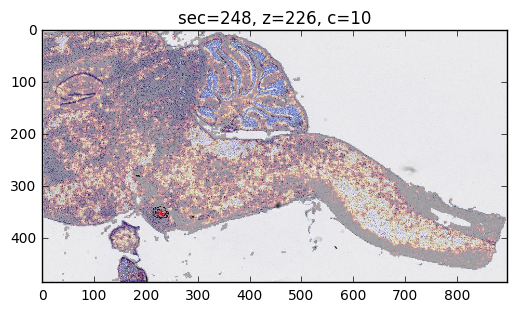

Error loading scoremap for section 249


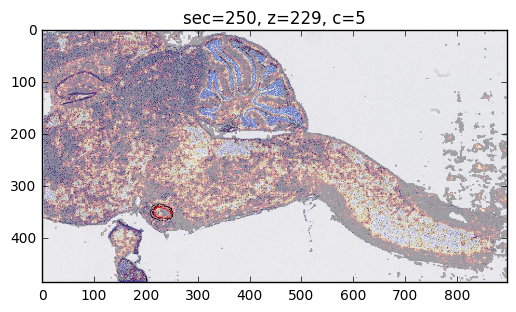

Error loading scoremap for section 251


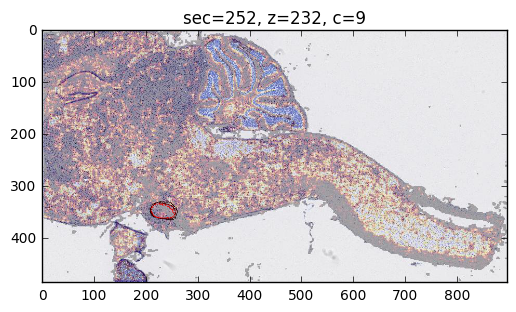

Error loading scoremap for section 253


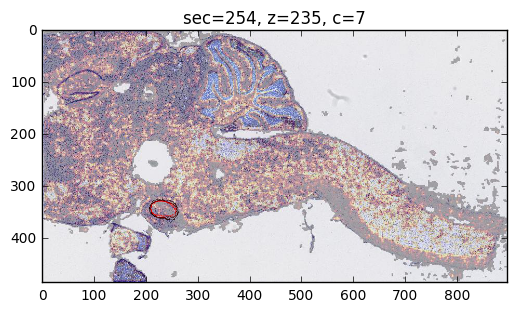

Error loading scoremap for section 255


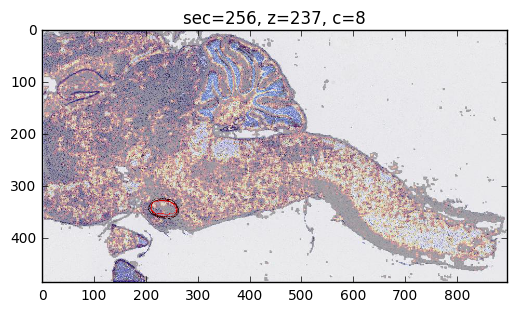

Error loading scoremap for section 257


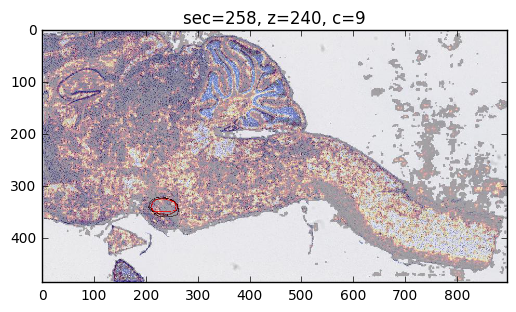

Error loading scoremap for section 259


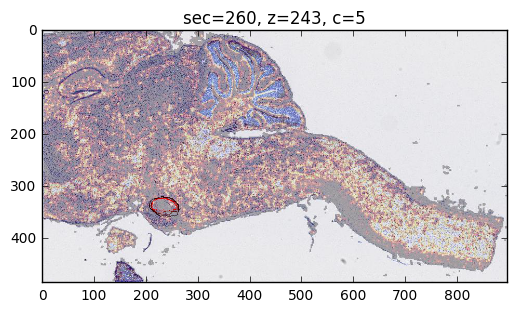

Error loading scoremap for section 261


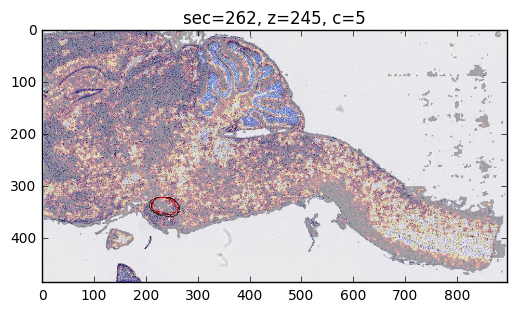

Error loading scoremap for section 263


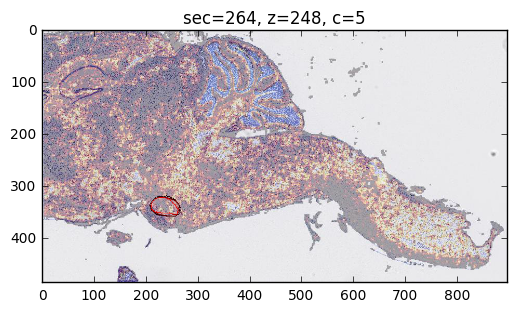

Error loading scoremap for section 265


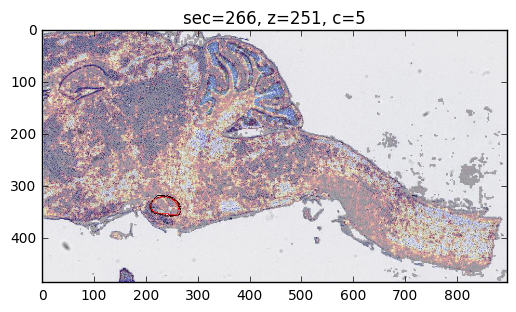

Error loading scoremap for section 267


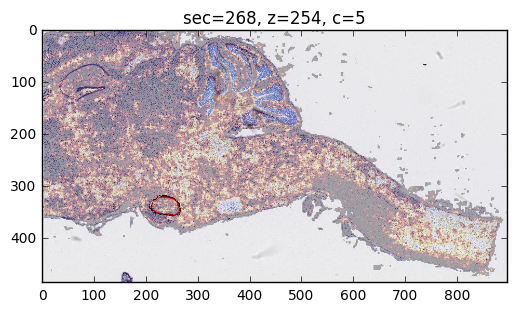

Error loading scoremap for section 269
Error loading scoremap for section 270


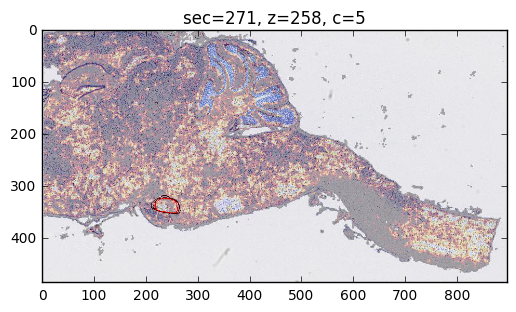

Error loading scoremap for section 272


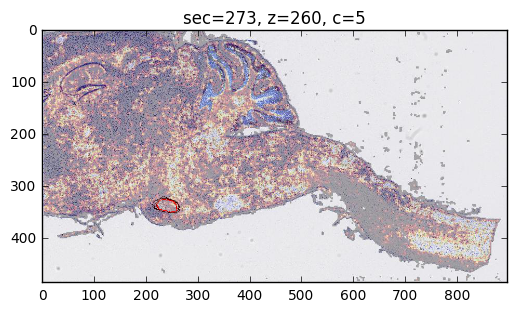

Error loading scoremap for section 274


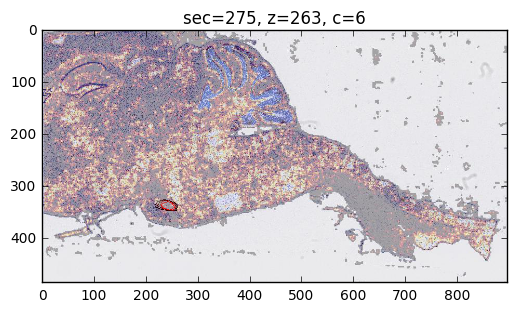

Error loading scoremap for section 276


In [119]:
# Generate overlay visualization

# For getting correct contour location

xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_volume_bbox(stack=stack_fixed, type='score', structure='7N', 
                             downscale=32, classifier_setting=classifier_setting)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# Generate atlas overlay image for every section

zf, zl = bbox_3d(volume_m_alignedTo_f)[4:]
sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

for sec in range(sec_first, sec_last+1):
# for sec in [155]:
    
    if is_invalid(metadata_cache['sections_to_filenames'][stack_fixed][sec]):
        continue
    
    try:
#         img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
#         img = imread(img_fn)
        img = imread(DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
                                                           downscale=32,
                                                           structure=convert_to_original_name(structure), 
                                                           setting=classifier_setting))
    except:
        sys.stderr.write('Error loading scoremap for section %d\n' % sec)
        continue
    
    viz = img.copy()
    
    z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
    z = int(z1)
    
    # Find moving volume annotation contours
    c = 0
    vol = volume_m_alignedTo_f
    for level in levels:
        cnts = find_contours(vol[..., z], level=level) # rows, cols
        c += len(cnts)
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:, ::-1] + (xmin_vol_f, ymin_vol_f)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
    if c > 0:    
#         plt.figure(figsize=(20,20));
        plt.figure();
        plt.title("sec=%d, z=%d, c=%d" % (sec, z, c));
        plt.imshow(viz);
        plt.show();
